In [1]:
import pandas as pd
import numpy as np
from numpy.random import randn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.proportion import proportions_ztest

import graphviz
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font', family = 'NanumBarunGothic')
matplotlib.rc('axes', unicode_minus = False)

### 타겟변수
- Price : 중고차 가격(단위:천원)

### 설명변수
- Name : 자동차 브랜드, 모델
- Location : 영업점 위치
- Year : 모델 연식
- Kilometers_Driven : 차량 누적 주행거리(Km)
- Fuel_Type : 자동차 사용연료
- Transmission : 변속방식(Manual/Automatic)
- Owner_Type : 소유권한 여부
- Mileage : 표준주행거리(kmpl)
- Engine : 엔진배기량(cc)
- Power : 엔진최대출력(bhp)
- Seats : 좌석 수
- New_Price : 신차 가격

# <span style="color:red"> 데이터 전처리</span>

In [2]:
def classify_city_income(city_name):
    high_income = {
        "Mumbai": "High",
        "Delhi": "High",
        "Bangalore": "High",
        "Chennai": "High"}

    mid_income = {
        "Hyderabad": "Median",
        "Ahmedabad": "Median",
        "Pune": "Median",
        "Kolkata": "Median",
        "Coimbatore": "Median"}
    
    low_income = {
        "Jaipur": "Low",
        "Kochi": "Low"}
    
    city_name = city_name.strip()
    
    if city_name in high_income:
        return high_income[city_name]
    elif city_name in mid_income:
        return mid_income[city_name]
    elif city_name in low_income:
        return low_income[city_name]
    else:
        return np.nan
    
    
def classify_car_by_seats(seat_count):
    if seat_count == 2:
        return "Sports Car"
    elif seat_count == 4:
        return "Sedan"
    elif seat_count == 5:
        return "Standard Car"
    elif seat_count in (6, 7):
        return "SUV"
    else:
        return "Large Vehicle"

brand_region = {
    # 유럽 (Europe)
    'Audi': 'Europe', 'BMW': 'Europe', 'Mercedes-Benz': 'Europe', 'Jaguar': 'Europe', 'Porsche': 'Europe', 'Bentley': 'Europe', 'Lamborghini': 'Europe',
    'Volvo': 'Europe', 'Land': 'Europe', 'Mini': 'Europe', 'Smart': 'Europe', 'Volkswagen': 'Europe', 'Skoda': 'Europe', 'OpelCorsa': 'Europe', 'Fiat': 'Europe',
    'Renault': 'Europe',
    # 일본 (Japan)
    'Toyota': 'Japan', 'Honda': 'Japan', 'Nissan': 'Japan', 'Mitsubishi': 'Japan', 'Datsun': 'Japan', 'Maruti': 'Japan',
    # 코리아 (Korea)
    'Hyundai': 'Korea', 'Kia': 'Korea',
    # 미국 (USA)
    'Ford': 'USA', 'Chevrolet': 'USA', 'Jeep': 'USA',
    # 기타 (Other) - 상업/유틸리티
    'ISUZU': 'Other', 'Force': 'Other', 'Hindustan': 'Other', 'Ambassador': 'Other',
    # 인도 (India) - Maruti와 Tata는 인도로 이동
    'Mahindra': 'India', 'Tata': 'India', 'Maruti': 'India',}
# Europe, Japan, Korea, USA, India, Other 6개의 지역 제조사
    
brand_categories = {
    'Audi': 'Luxury', 'BMW': 'Luxury', 'Mercedes-Benz': 'Luxury', 'Jaguar': 'Luxury', 'Porsche': 'Luxury', 'Bentley': 'Luxury', 'Lamborghini': 'Luxury',
    'Volvo': 'Premium', 'Land': 'Premium', 'Mini': 'Premium', 'Smart': 'Premium',
    'Toyota': 'Mainstream', 'Honda': 'Mainstream', 'Hyundai': 'Mainstream', 'Nissan': 'Mainstream', 'Volkswagen': 'Mainstream', 'Ford': 'Mainstream', 'Chevrolet': 'Mainstream',
    'Maruti': 'Economy', 'Tata': 'Economy', 'Mahindra': 'Economy', 'Datsun': 'Economy', 'Fiat': 'Economy', 'Renault': 'Economy', 'Skoda': 'Economy', 'Jeep': 'Economy', 'OpelCorsa': 'Economy',
    'ISUZU': 'Commercial/Utility', 'Force': 'Commercial/Utility', 'Hindustan': 'Commercial/Utility', 'Ambassador': 'Commercial/Utility', 'Mitsubishi': 'Mainstream'}

In [3]:
df = pd.read_csv("/home/piai/다운로드/01_실습파일/2. Big Data 분석/Car.csv")
df.shape

(7253, 13)

- 연속형 변수의 단위를 제거하고 실수변환합니다

In [4]:
df['Engine'] = df['Engine'].replace(['null', '0 CC'], np.nan).astype(str).str.replace(' CC', '').astype(float)
df['Power'] = df['Power'].replace(['null bhp', '0 bhp'], np.nan).astype(str).str.replace(' bhp', '').astype(float)
df['Mileage'] = df['Mileage'].replace('null kmpl', np.nan).astype(str).str.replace(' kmpl', '').astype(str).str.replace(' km/kg', '').astype(float)

- 오너 타입 변수는 레이블인코딩합니다.

In [5]:
Owner_Type = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
df['Owner_Type_Num'] = df['Owner_Type'].map(Owner_Type)

In [6]:
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Owner_Type_Num
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,1
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,1
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,1
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,2


- 데이터 타입과 널값을 확인합니다.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   float64
 9   Engine             7207 non-null   float64
 10  Power              7078 non-null   float64
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
 13  Owner_Type_Num     7253 non-null   int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 793.4+ KB


- 연속 및 범주형 자료들의 기술통계량을 확인합니다.

In [8]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_Num
count,6200.000000,7253.000000,7.253000e+03,7251.000000,7207.000000,7078.000000,7200.000000,7253.000000
mean,14912.514750,2013.365366,5.869906e+04,18.141580,1616.573470,112.765214,5.279722,1.201572
std,17674.318464,3.254421,8.442772e+04,4.562197,595.285137,53.493553,0.811660,0.456808
min,7.080000,1996.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,1.000000
25%,5365.360000,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000,1.000000
50%,8814.520000,2014.000000,5.341600e+04,18.160000,1493.000000,94.000000,5.000000,1.000000
75%,15869.972500,2016.000000,7.300000e+04,21.100000,1968.000000,138.100000,5.000000,1.000000
max,245273.600000,2019.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,4.000000


In [9]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,New_Price
count,7253,7253,7253,7253,7253,1006
unique,2041,11,5,2,4,625
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,63.71 Lakh
freq,55,949,3852,5204,5952,6


- 약 7300개의 데이터 행개수의 대다수가 널값인 New_Price 열은 지워주었습니다

In [10]:
df.drop(labels = 'New_Price', axis = 1, inplace = True)

- Engine과 Power, Mileage 값의 경우 회귀모델을 설계하여 널값을 제외한 값들로 학습시키고 비어있는 값들을 에측하여 넣어주었습니다. 200개정도의 널값이 있었기에 과적합의 우려가 적을것이라 판단했습니다.

In [11]:
missing_engine_indices = df[df['Engine'].isnull() | (df['Engine'] == 0)].index

imputer = SimpleImputer(strategy='mean')
df[['Engine', 'Power', 'Mileage']] = imputer.fit_transform(df[['Engine', 'Power', 'Mileage']])

engine_data = df[['Engine', 'Power', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
engine_data = pd.get_dummies(engine_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = engine_data[engine_data['Engine'].notnull() | (engine_data['Engine'] == 0)]
predict_data = engine_data.loc[missing_engine_indices]

X_train = train_data.drop('Engine', axis=1)
y_train = train_data['Engine']
X_predict = predict_data.drop('Engine', axis=1)

if not X_predict.empty:
    engine_model = RandomForestRegressor(n_estimators=100, random_state=42)
    engine_model.fit(X_train, y_train)

    predicted_engines = engine_model.predict(X_predict)
    df.loc[missing_engine_indices, 'Engine'] = predicted_engines

In [12]:
missing_power_indices = df[df['Power'].isnull() | (df['Power'] == 0)].index

power_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
power_data = pd.get_dummies(power_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = power_data[power_data['Power'].notnull()| (engine_data['Power'] == 0)]
predict_data = power_data.loc[missing_power_indices]

X_train = train_data.drop('Power', axis=1)
y_train = train_data['Power']
X_predict = predict_data.drop('Power', axis=1)

if not X_predict.empty:
    power_model = RandomForestRegressor(n_estimators=100, random_state=42)
    power_model.fit(X_train, y_train)

    predicted_powers = power_model.predict(X_predict)
    df.loc[missing_power_indices, 'Power'] = predicted_powersMaruti

In [13]:
# missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

# mileage_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
# mileage_data = pd.get_dummies(mileage_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

# train_data = mileage_data[mileage_data['Mileage'].notnull() | (engine_data['Mileage'] == 0)]
# predict_data = mileage_data.loc[missing_mileage_indices]

# X_train = train_data.drop('Mileage', axis=1)
# y_train = train_data['Mileage']
# X_predict = predict_data.drop('Mileage', axis=1)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# if not X_predict.empty:
#     param_grid = {
#         'n_estimators': [50 * i for i in range(1, 6)], 
#         'max_depth': [i for i in range(1, 11)],
#         'min_samples_split': [10 * i for i in range(1, 11)], 
#         'min_samples_leaf': [5 * i for i in range(1, 6)]
#     }

#     grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(X_train, y_train)

#     best_params = grid_search.best_params_
#     print("Best Parameters:", best_params)

#     best_model = grid_search.best_estimator_
#     predicted_mileages = best_model.predict(X_predict)

#     df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

In [14]:
missing_mileage_indices = df[df['Mileage'].isnull() | (df['Mileage'] == 0)].index

mileage_data = df[['Power', 'Engine', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage']]
mileage_data = pd.get_dummies(mileage_data, columns=['Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

train_data = mileage_data[mileage_data['Mileage'].notnull() | (engine_data['Mileage'] == 0)]
predict_data = mileage_data.loc[missing_mileage_indices]

X_train = train_data.drop('Mileage', axis=1)
y_train = train_data['Mileage']
X_predict = predict_data.drop('Mileage', axis=1)

if not X_predict.empty:
    mileages_model = RandomForestRegressor(max_depth = 10, min_samples_leaf = 5, min_samples_split = 10, n_estimators = 250, random_state=42)
    mileages_model.fit(X_train, y_train)
    
    predicted_mileages = mileages_model.predict(X_predict)
    df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

In [15]:
# val_predictions = best_model.predict(X_val)
# print("Validation MAE:", mean_absolute_error(y_val, val_predictions))
# print("Validation MSE:", mean_squared_error(y_val, val_predictions))
# print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_predictions)))
# print("Validation R^2 Score:", r2_score(y_val, val_predictions))

# predicted_mileages = best_model.predict(X_predict)
# df.loc[missing_mileage_indices, 'Mileage'] = predicted_mileages

- 연도는 현재 년도 기준으로 개별 값들을 빼주어 계산하였습니다.

In [16]:
df['Year'] = 2024 - df['Year']

- 가설 수립 및 예측 모델링 과정에서 편의성을 높여주기 위해서 파생변수들을 생성하였습니다.

In [17]:
df['Location_income'] = df['Location'].apply(classify_city_income)
df['Car_cate'] = df['Seats'].apply(classify_car_by_seats)
df['Brand'] = df['Name'].apply(lambda x :x.split()[0])
df['Brand_Category'] = df['Brand'].str.split().str[0].map(brand_categories).fillna('Unknown')
df['Ownership_Level'] = df['Owner_Type'].apply(lambda x: 'Little' if x in ['First', 'Second'] else 'Much')
df['brand_Region'] = df['Brand'].map(brand_region)

- Seats 값의 경우 7인 모델하나를 제외하고 나머지 모델은 전부 5인승이기에 서칭한 데이터를 기반으로 값을 넣어주었습니다.

In [18]:
condition = (df['Seats'].isnull() & (df['Name'] == 'Mahindra TUV 300 P4'))
df.loc[condition, 'Seats'] = 7

condition1 = (df['Seats'].isnull() & (df['Name'] != 'Mahindra TUV 300 P4'))
df.loc[condition1, 'Seats'] = 5

df.loc[3999, 'Seats'] = 5

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7253 non-null   float64
 9   Engine             7253 non-null   float64
 10  Power              7253 non-null   float64
 11  Seats              7253 non-null   float64
 12  Owner_Type_Num     7253 non-null   int64  
 13  Location_income    7253 non-null   object 
 14  Car_cate           7253 non-null   object 
 15  Brand              7253 non-null   object 
 16  Brand_Category     7253 

In [20]:
df.describe()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_Num
count,6200.000000,7253.000000,7.253000e+03,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000
mean,14912.514750,10.634634,5.869906e+04,18.225855,1616.238304,112.765214,5.278643,1.201572
std,17674.318464,3.254421,8.442772e+04,4.305160,593.439536,52.844178,0.806915,0.456808
min,7.080000,5.000000,1.710000e+02,2.039230,72.000000,34.200000,2.000000,1.000000
25%,5365.360000,8.000000,3.400000e+04,15.200000,1198.000000,77.000000,5.000000,1.000000
50%,8814.520000,10.000000,5.341600e+04,18.160000,1493.000000,98.600000,5.000000,1.000000
75%,15869.972500,13.000000,7.300000e+04,21.100000,1968.000000,138.030000,5.000000,1.000000
max,245273.600000,28.000000,6.500000e+06,33.540000,5998.000000,616.000000,10.000000,4.000000


In [21]:
df.describe(include = 'object')

,Name,Location,Fuel_Type,Transmission,Owner_Type,Location_income,Car_cate,Brand,Brand_Category,Ownership_Level,brand_Region
count,7253,7253,7253,7253,7253,7253,7253,7253,7253,7253,7253
unique,2041,11,5,2,4,3,5,32,5,2,6
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,Median,Standard Car,Maruti,Mainstream,Little,India
freq,55,949,3852,5204,5952,3342,6047,1444,3619,7104,2003


# <span style="color:red"> 그래프 분석 및 이상치 제거</span>

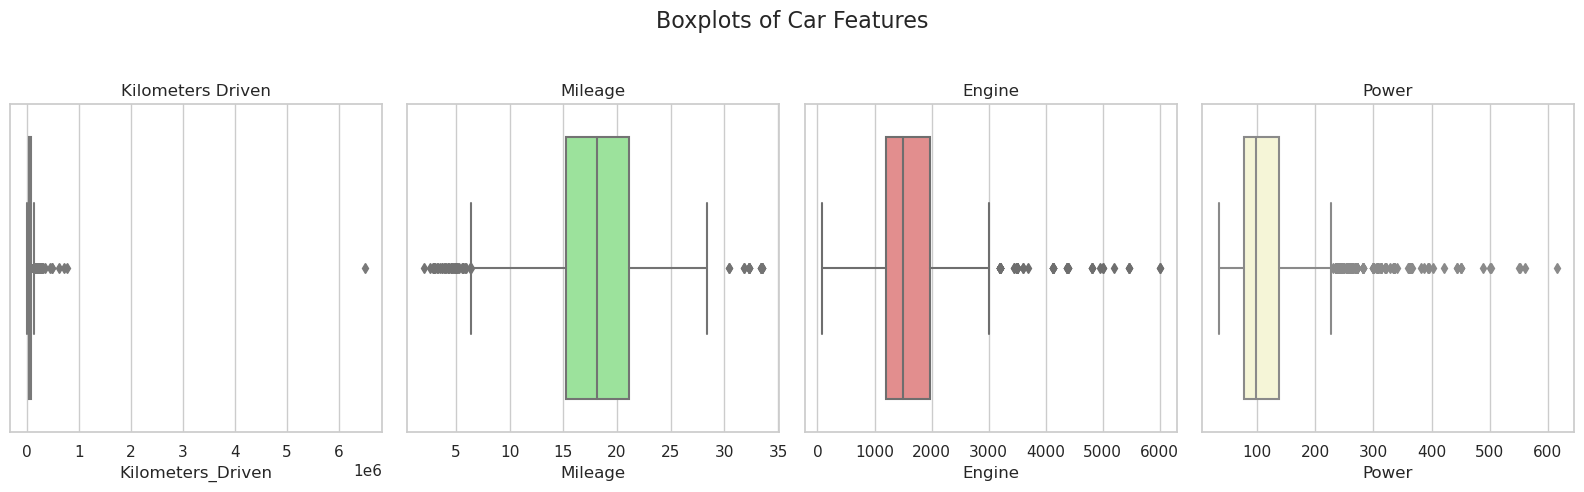

In [22]:
sns.set(style="whitegrid")

# 서브플롯 생성
fig, ax = plt.subplots(1, 4, figsize=(16, 5), sharey=True)

# 박스플롯 그리기
sns.boxplot(x=df['Kilometers_Driven'], ax=ax[0], color="lightblue")
ax[0].set_title("Kilometers Driven")

sns.boxplot(x=df['Mileage'], ax=ax[1], color="lightgreen")
ax[1].set_title("Mileage")

sns.boxplot(x=df['Engine'], ax=ax[2], color="lightcoral")
ax[2].set_title("Engine")

sns.boxplot(x=df['Power'], ax=ax[3], color="lightgoldenrodyellow")
ax[3].set_title("Power")

# 전체 제목 및 레이아웃 조정
fig.suptitle("Boxplots of Car Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

- 상용차 기준 Kilometers_Driven의 값이 300,000이상인 데이터는 이상치로 판단하여 제거하였습니다.

In [23]:
df.drop(df[df['Kilometers_Driven'] > 300000].index, inplace=True)

- 표준주행거리가 너무 낮게 나오는 데이터도 이상치로 판단하여 제거하였습니다.

In [24]:
df.drop(df[df['Mileage'] < 5].index, inplace=True)

- 엔진cc는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [25]:
df = df.drop(df[(df['Engine'] > 4000) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df = df.drop(df[df['Engine'] < 800].index)

- 마력 수치는 고급형이 아닌차가 수치가 높게 나오는 경우 이상치로 간주하여 제거하였습니다. 너무 낮은 값도 제거하였습니다.

In [26]:
df.drop(df[(df['Power'] > 400) & (~df['Brand_Category'].isin(['Luxury', 'Premium']))].index)
df.drop(df[(df['Power'] < 60)].index)

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Owner_Type_Num,Location_income,Car_cate,Brand,Brand_Category,Ownership_Level,brand_Region
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,9,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,1,Median,Standard Car,Hyundai,Mainstream,Little,Korea
2,Honda Jazz V,Chennai,6898.32,13,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,1,High,Standard Car,Honda,Mainstream,Little,Japan
3,Maruti Ertiga VDI,Chennai,9197.76,12,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,1,High,SUV,Maruti,Economy,Little,India
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,11,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,2,Median,Standard Car,Audi,Luxury,Little,Europe
6,Nissan Micra Diesel XV,Jaipur,5365.36,11,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,1,Low,Standard Car,Nissan,Mainstream,Little,Japan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7248,Volkswagen Vento Diesel Trendline,Hyderabad,NaN,13,89411,Diesel,Manual,First,20.54,1598.0,103.60,5.0,1,Median,Standard Car,Volkswagen,Mainstream,Little,Europe
7249,Volkswagen Polo GT TSI,Mumbai,NaN,9,59000,Petrol,Automatic,First,17.21,1197.0,103.60,5.0,1,High,Standard Car,Volkswagen,Mainstream,Little,Europe
7250,Nissan Micra Diesel XV,Kolkata,NaN,12,28000,Diesel,Manual,First,23.08,1461.0,63.10,5.0,1,Median,Standard Car,Nissan,Mainstream,Little,Japan
7251,Volkswagen Polo GT TSI,Pune,NaN,11,52262,Petrol,Automatic,Third,17.20,1197.0,103.60,5.0,3,Median,Standard Car,Volkswagen,Mainstream,Much,Europe


columns_to_encode = ['Transmission', 'Owner_Type', 'Fuel_Type', 'Owner_Type', 'Location_income','Car_cate','Brand_Category']

df = pd.get_dummies(df, columns=columns_to_encode)

<Axes: xlabel='Kilometers_Driven', ylabel='Price'>

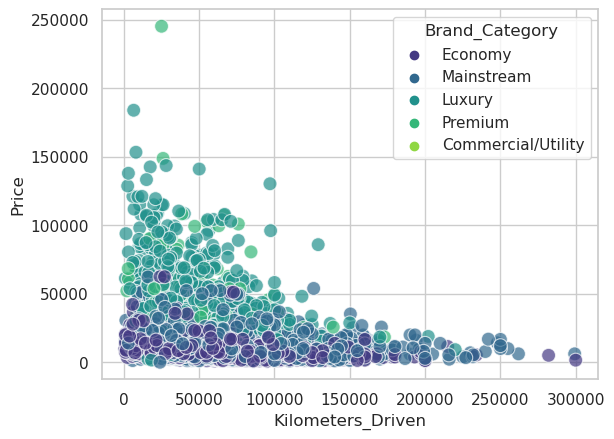

In [27]:
sns.set(style="whitegrid")
sns.scatterplot(x=df['Kilometers_Driven'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Year', ylabel='Price'>

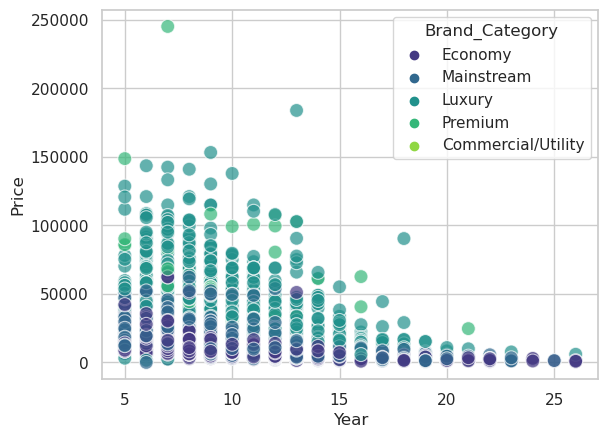

In [28]:
sns.scatterplot(x=df['Year'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Mileage', ylabel='Price'>

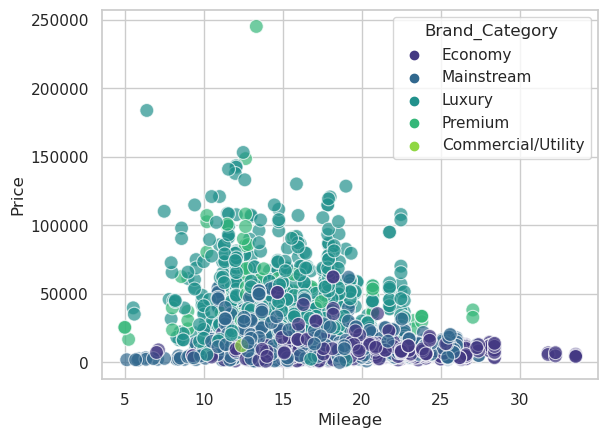

In [29]:
sns.scatterplot(x=df['Mileage'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Engine', ylabel='Price'>

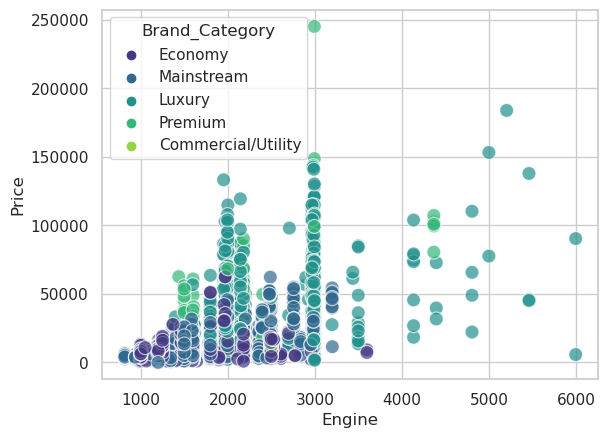

In [30]:
sns.scatterplot(x=df['Engine'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

<Axes: xlabel='Power', ylabel='Price'>

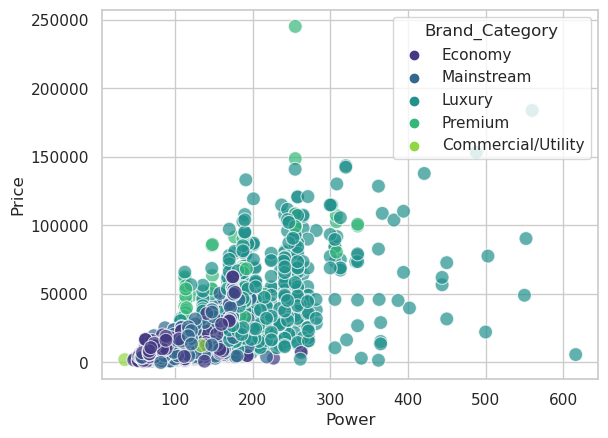

In [31]:
sns.scatterplot(x=df['Power'], y=df['Price'], 
                hue=df['Brand_Category'],  # 색상으로 브랜드 구분
                palette='viridis',  # 색상 팔레트
                s=100,  # 점의 크기
                edgecolor='w',  # 점의 가장자리 색상
                alpha=0.7)

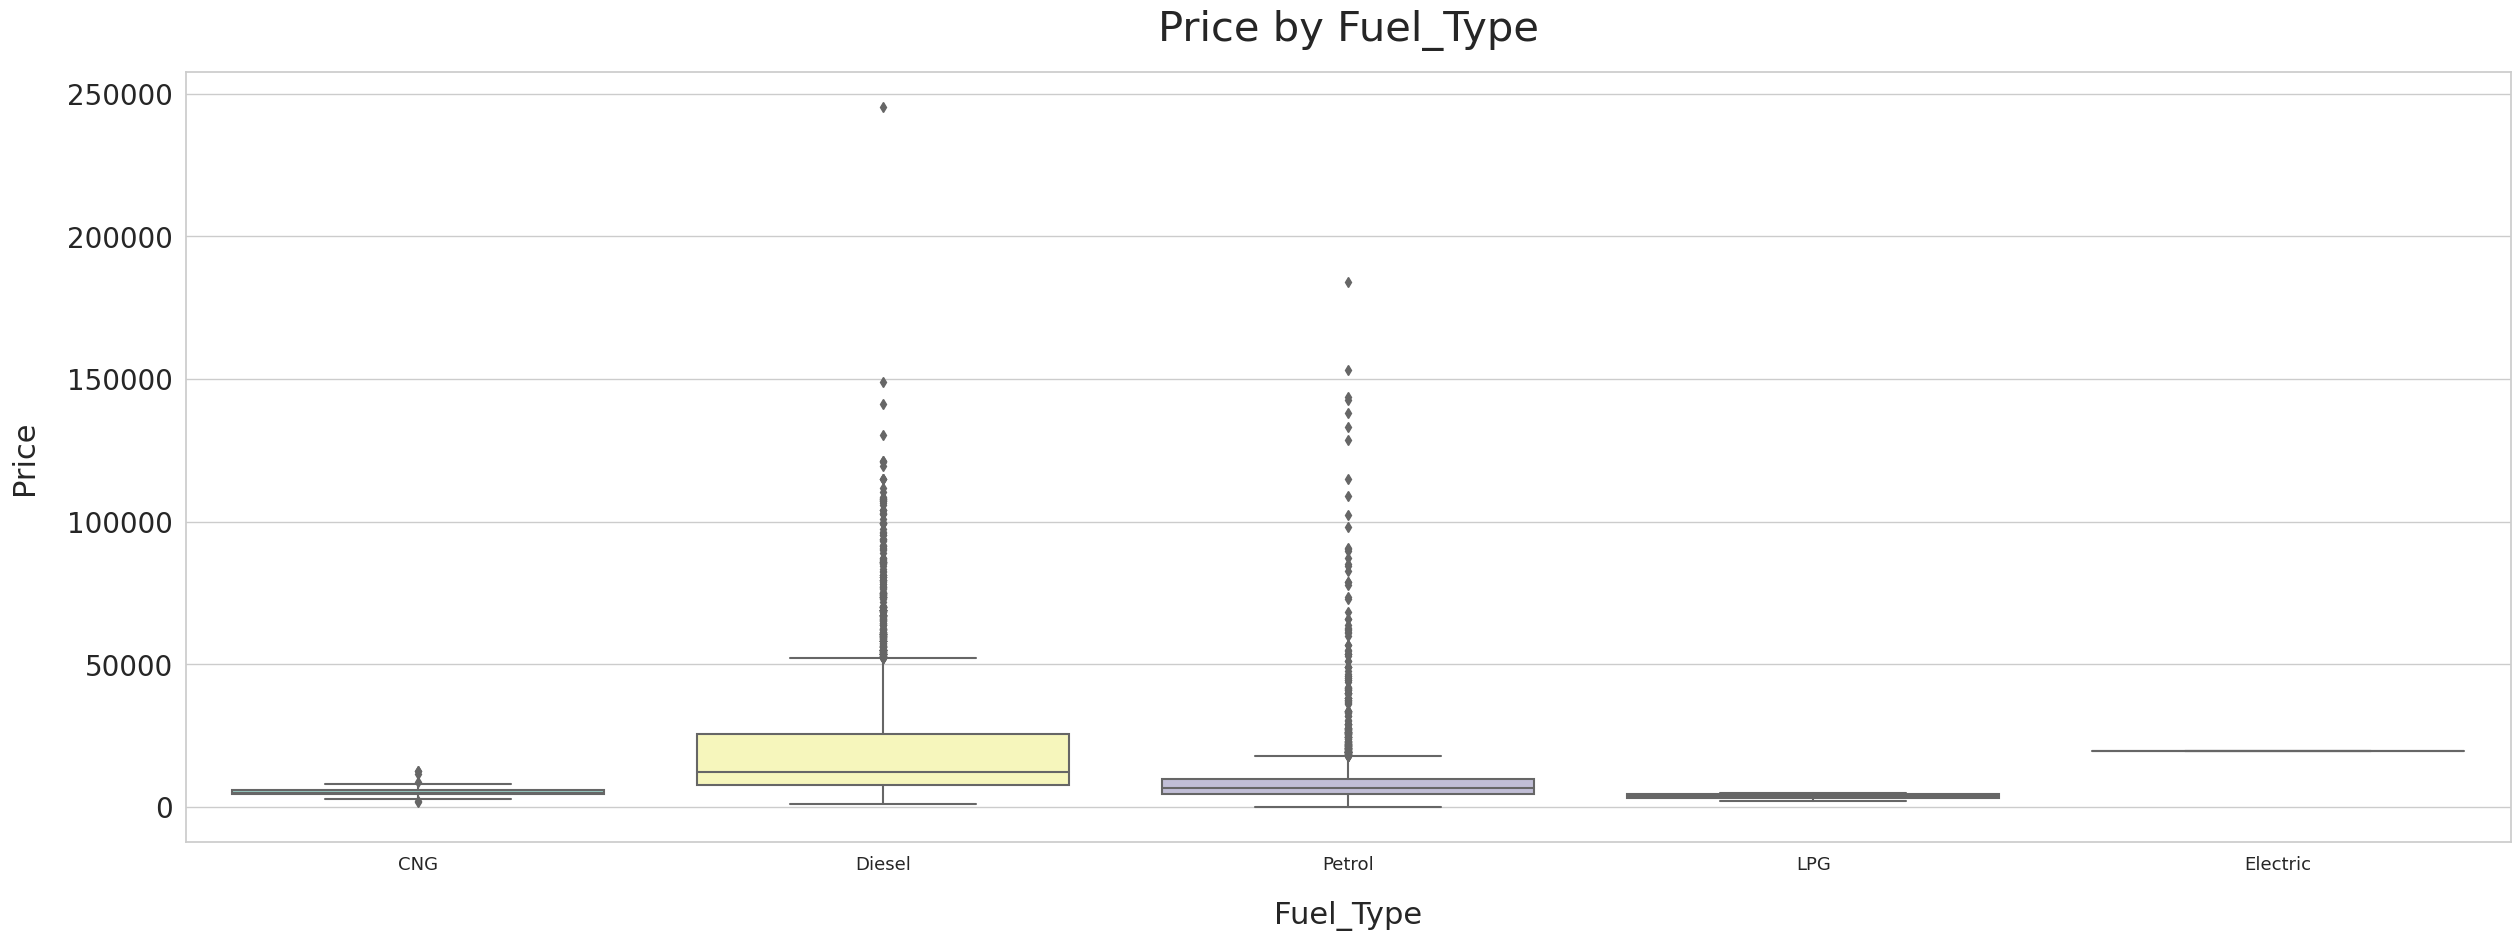

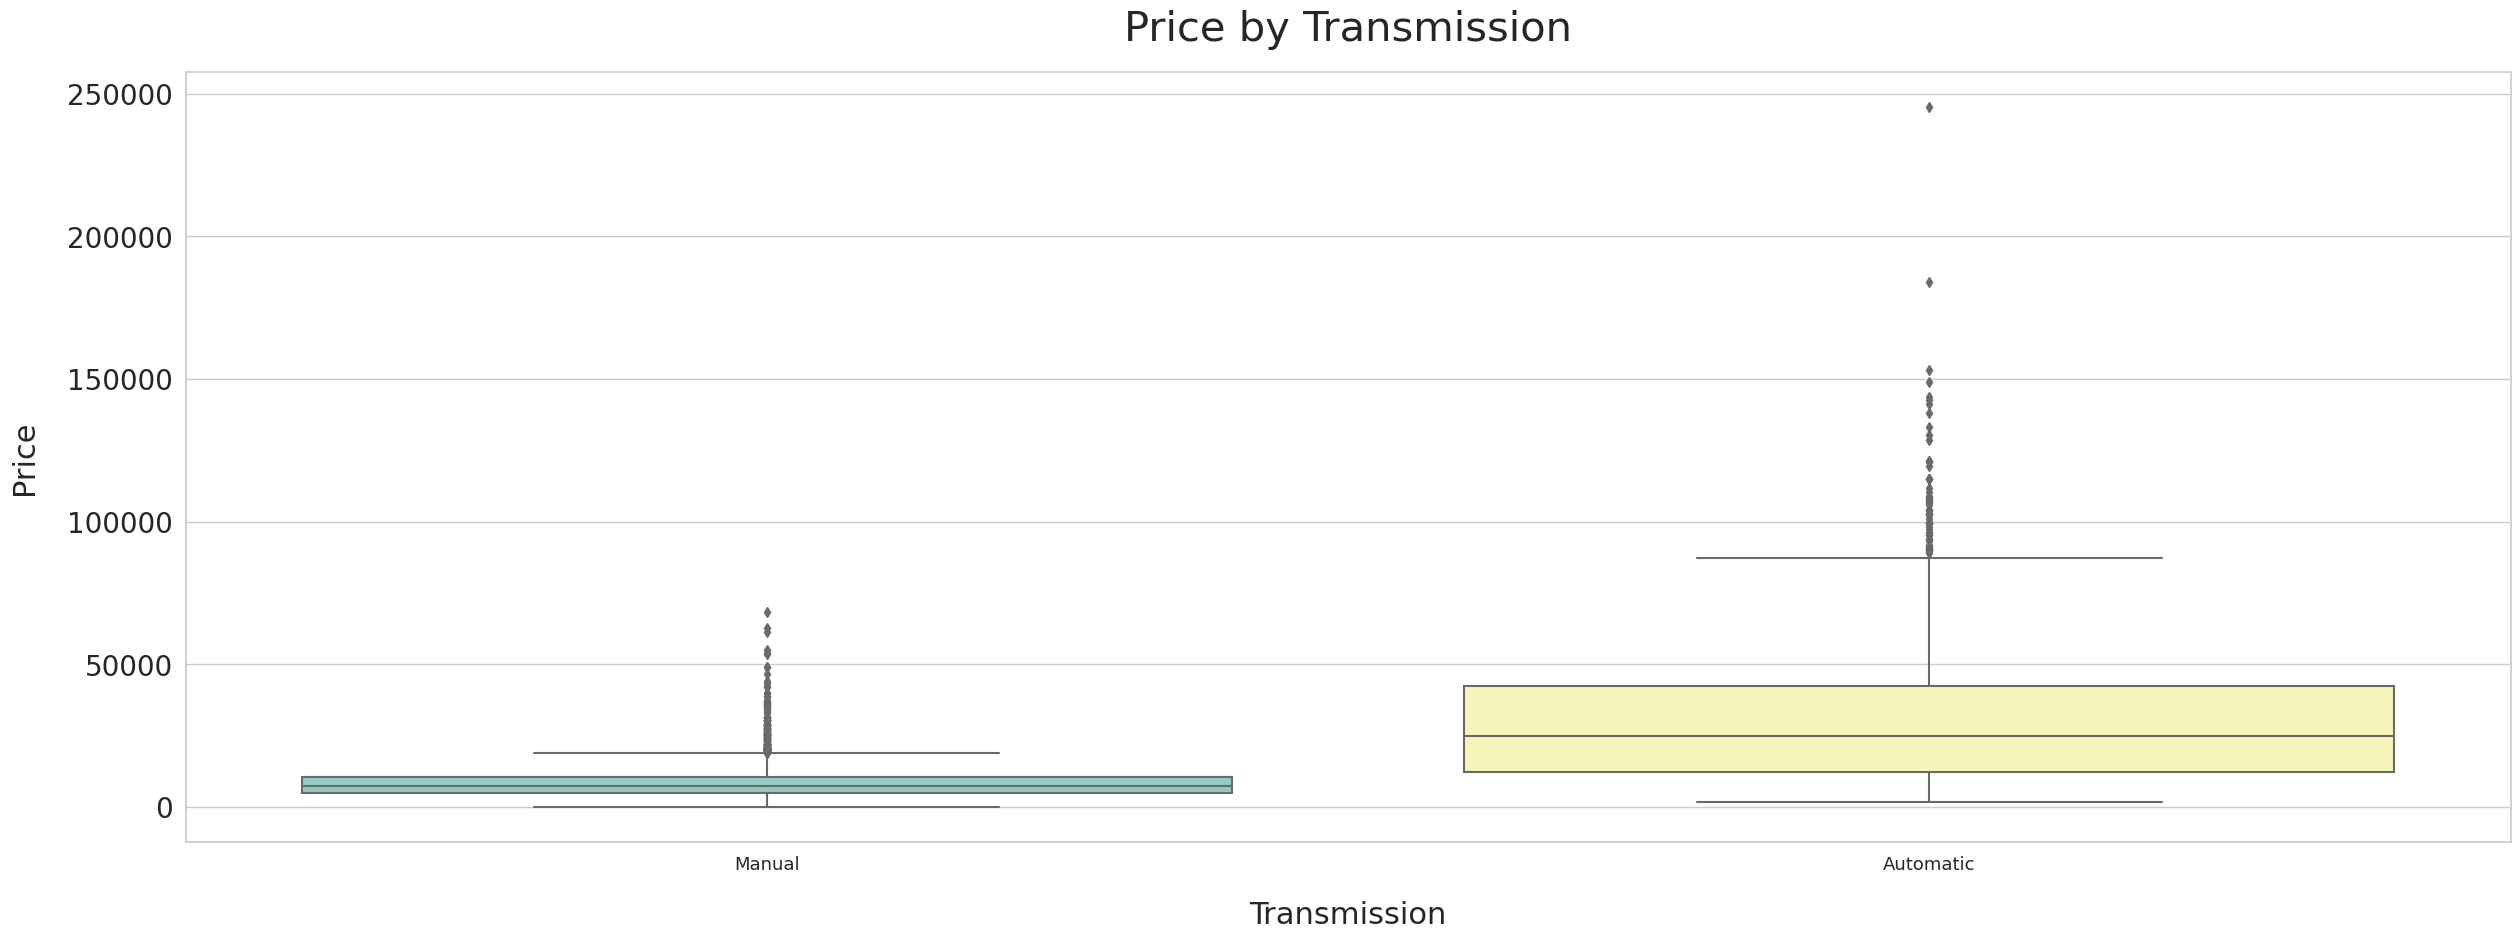

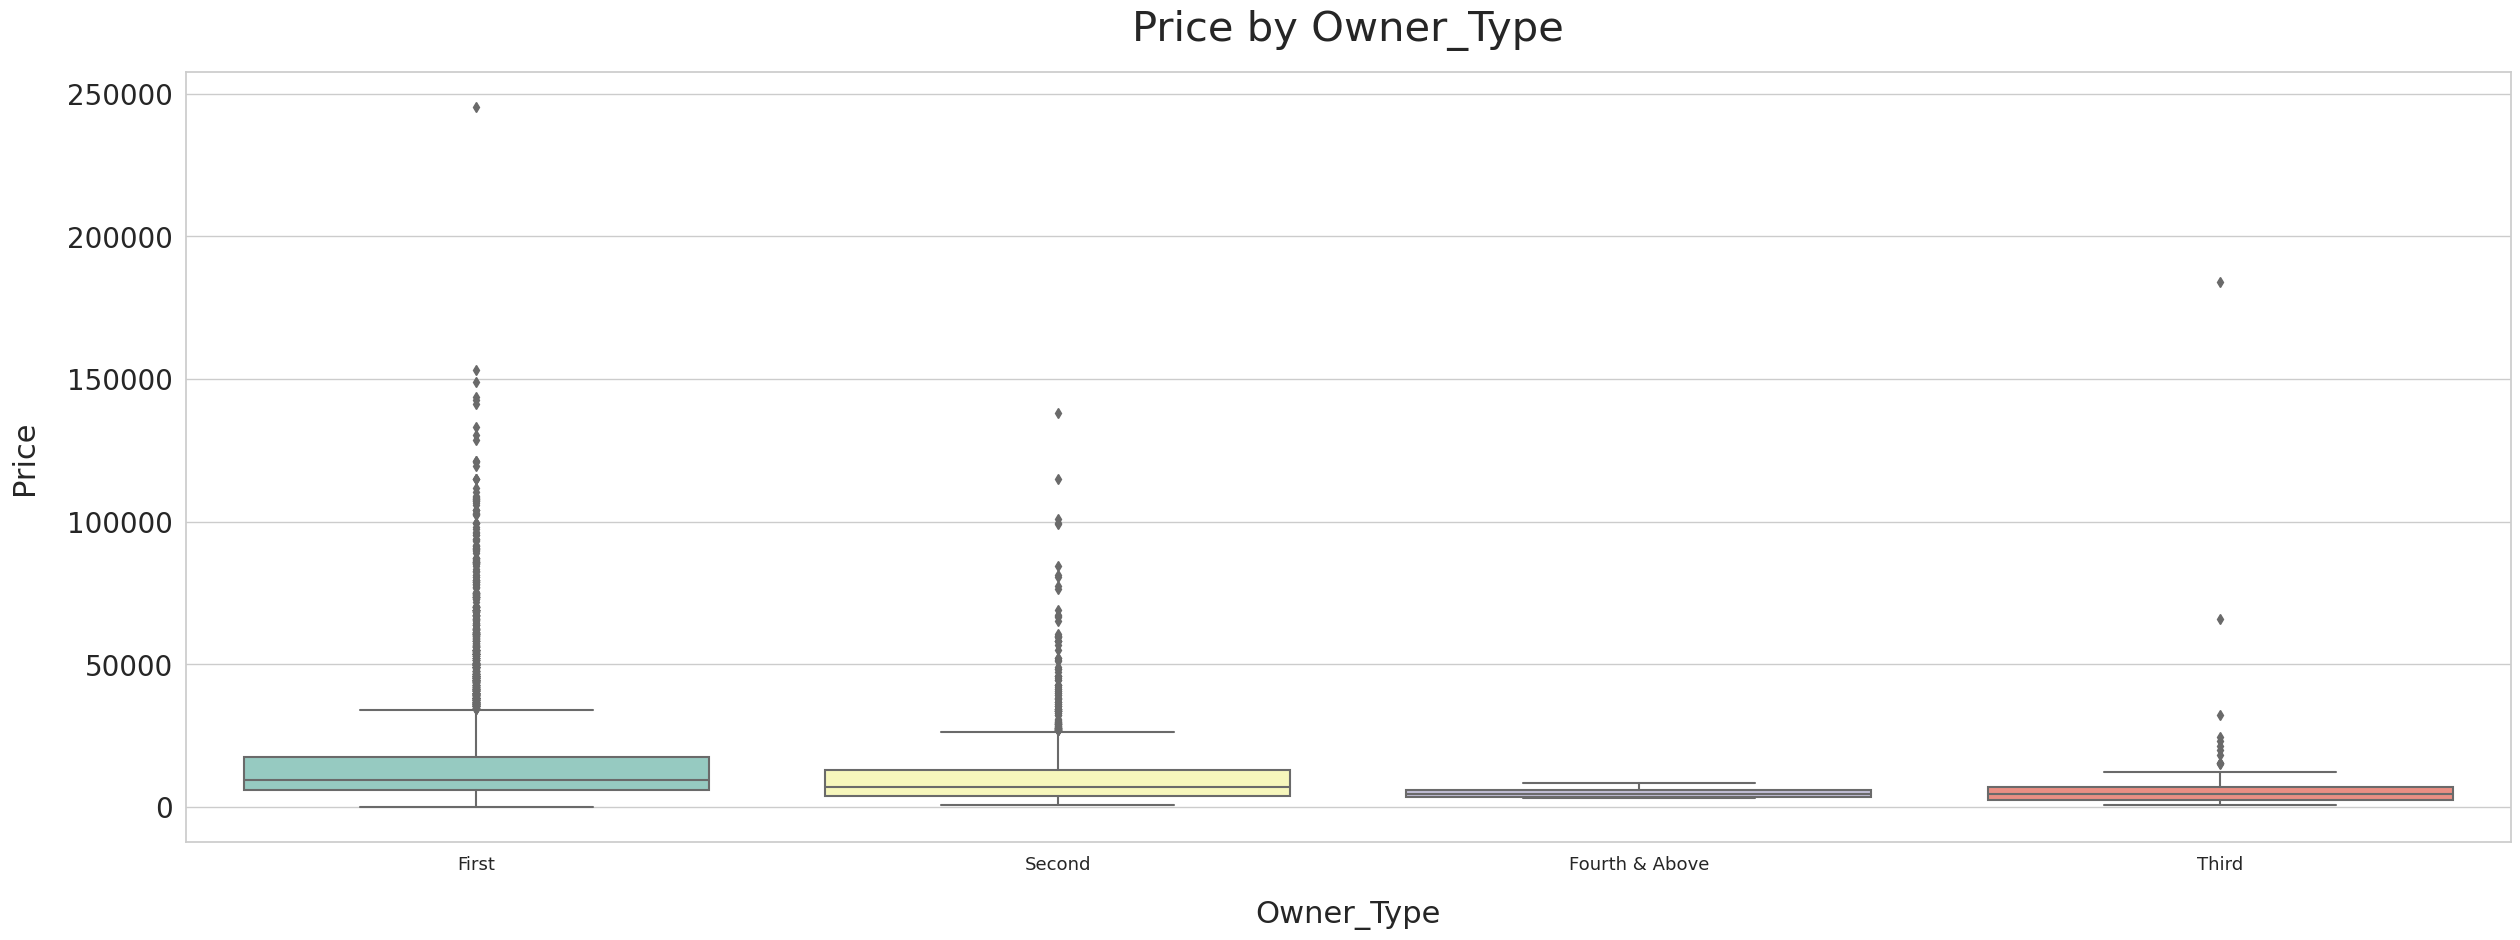

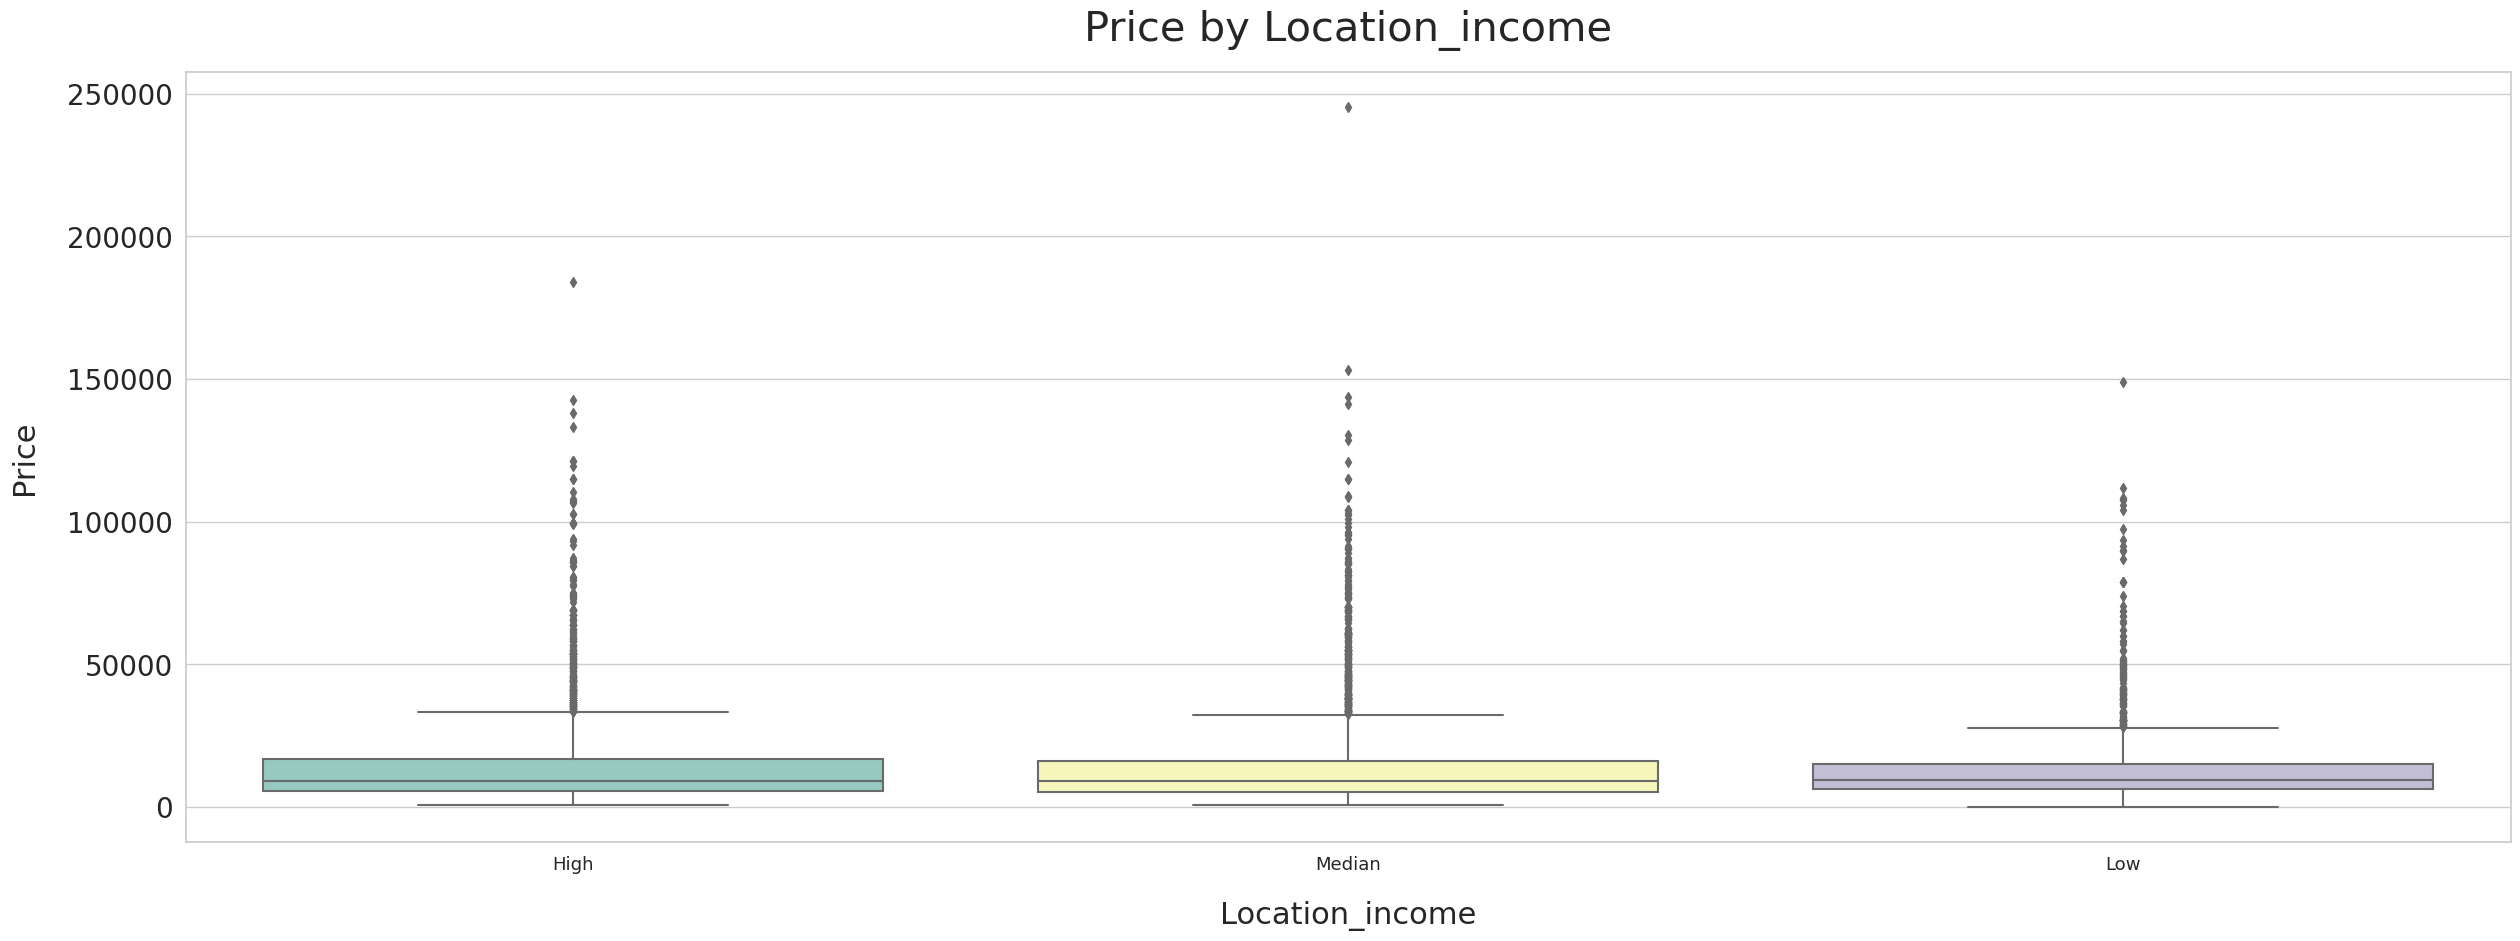

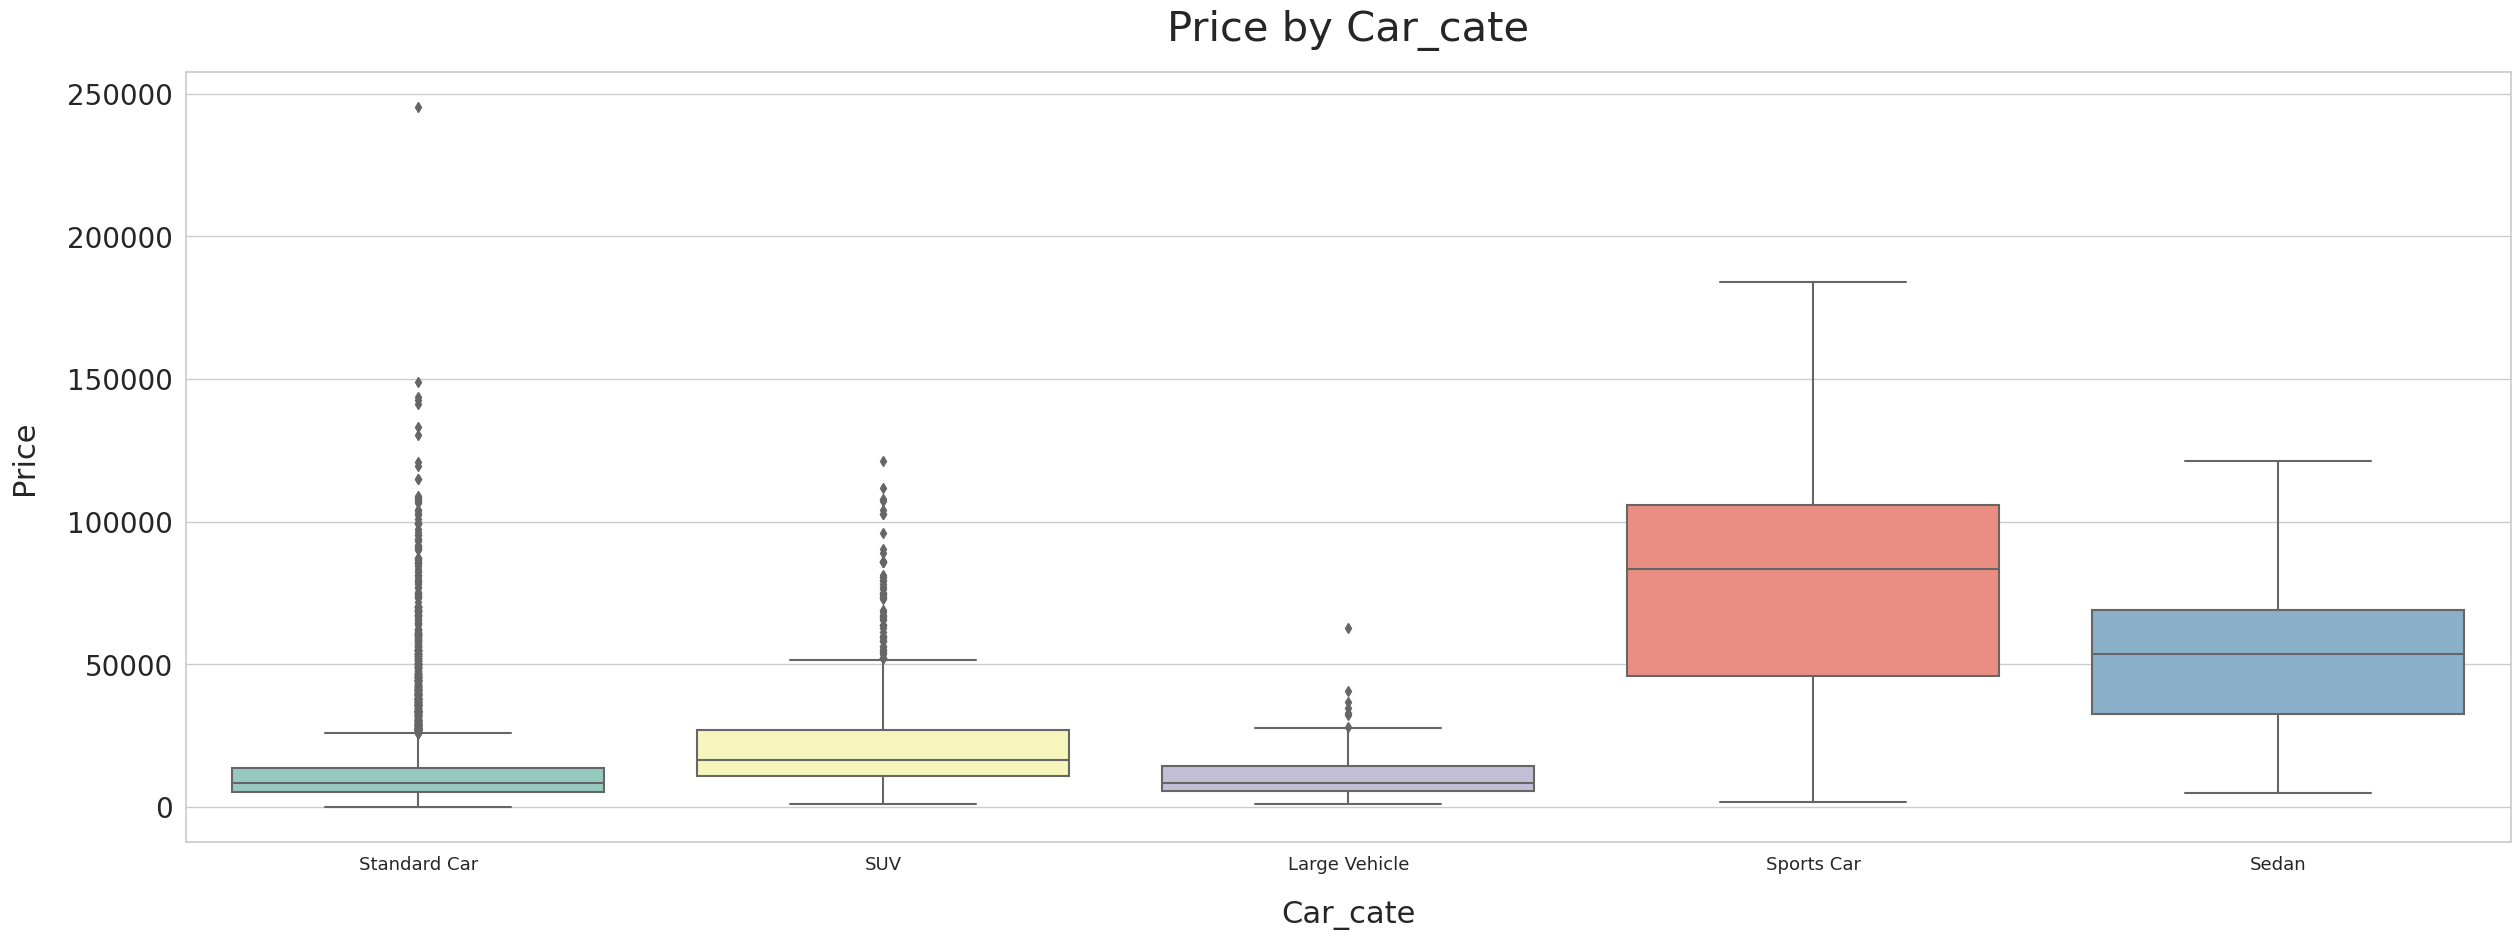

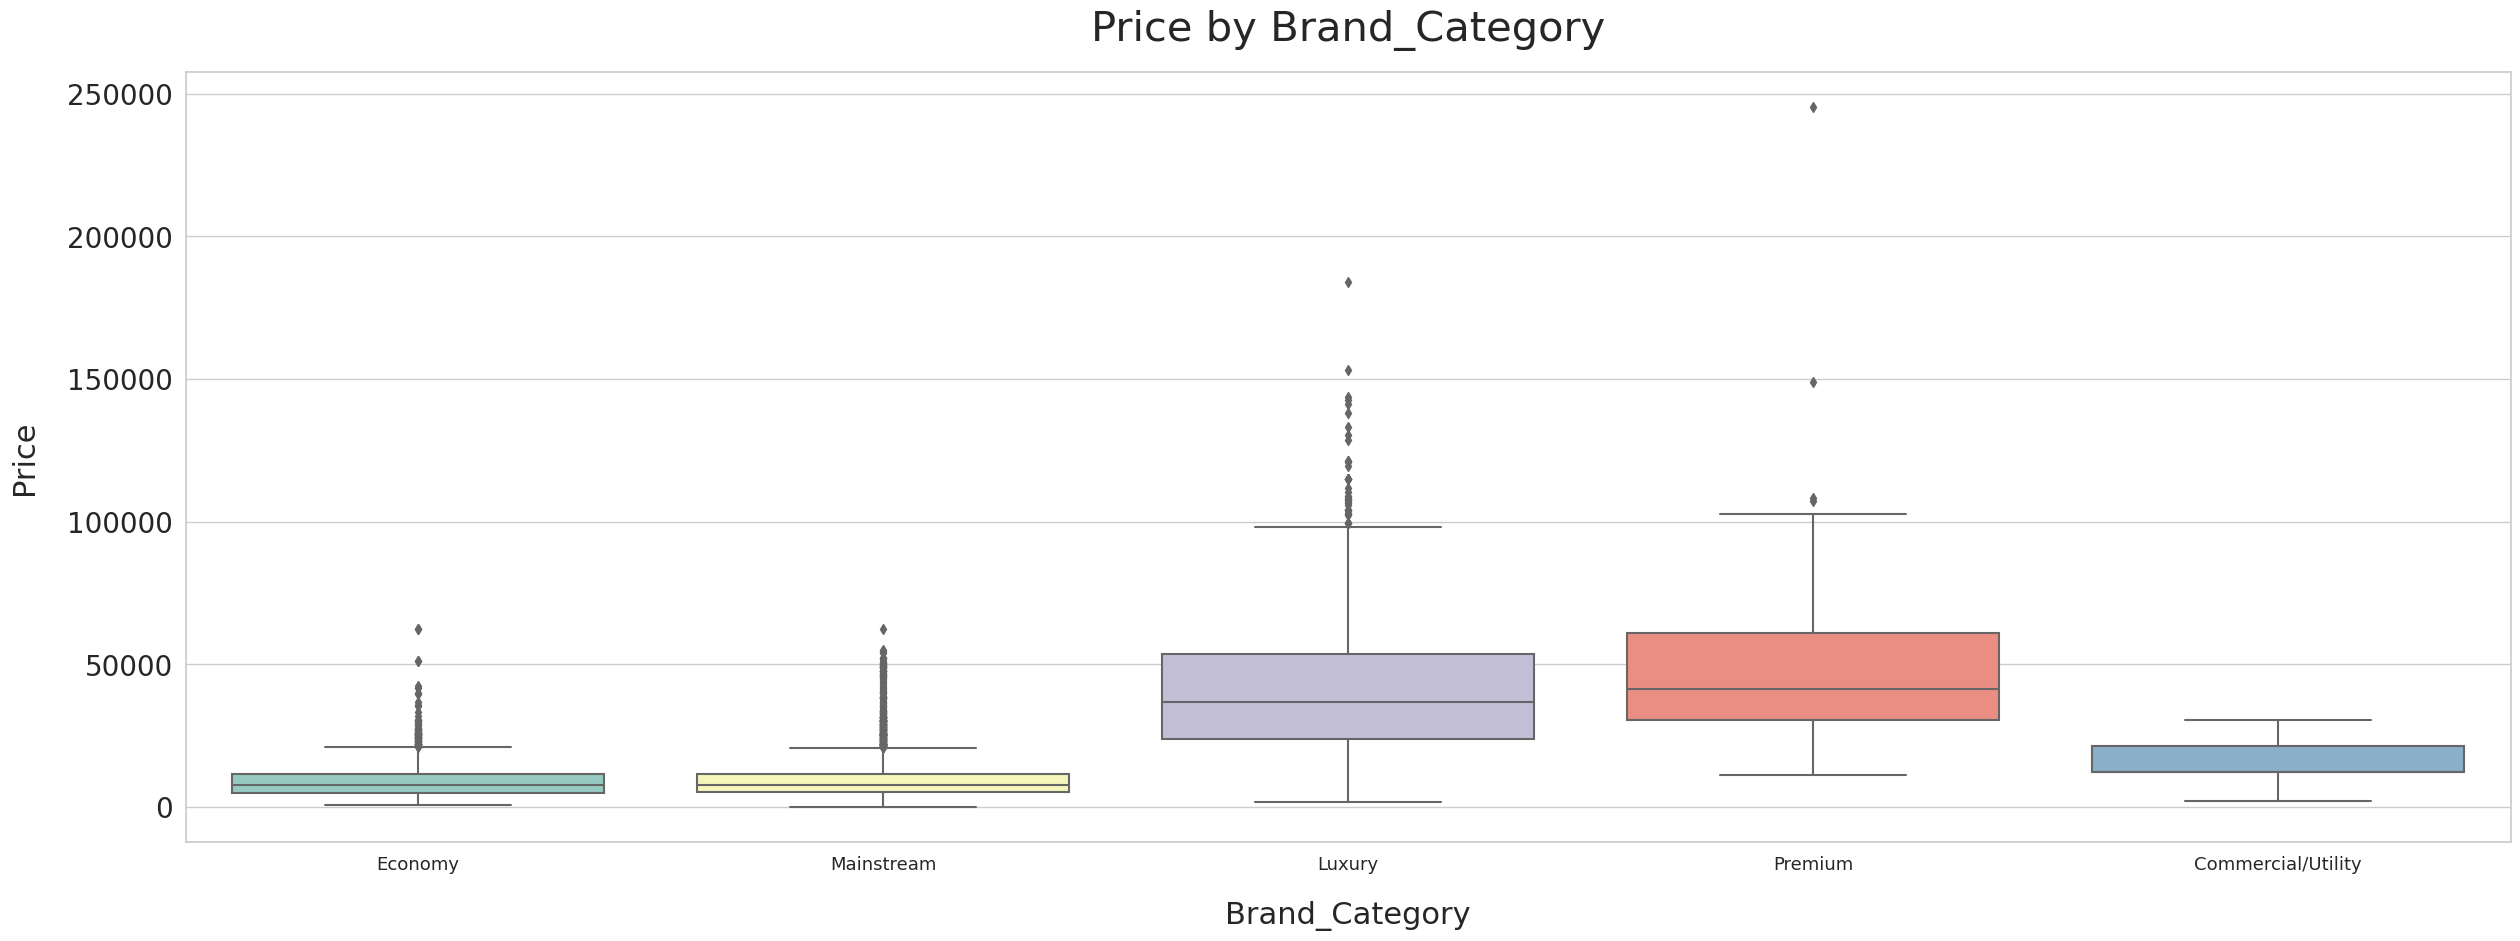

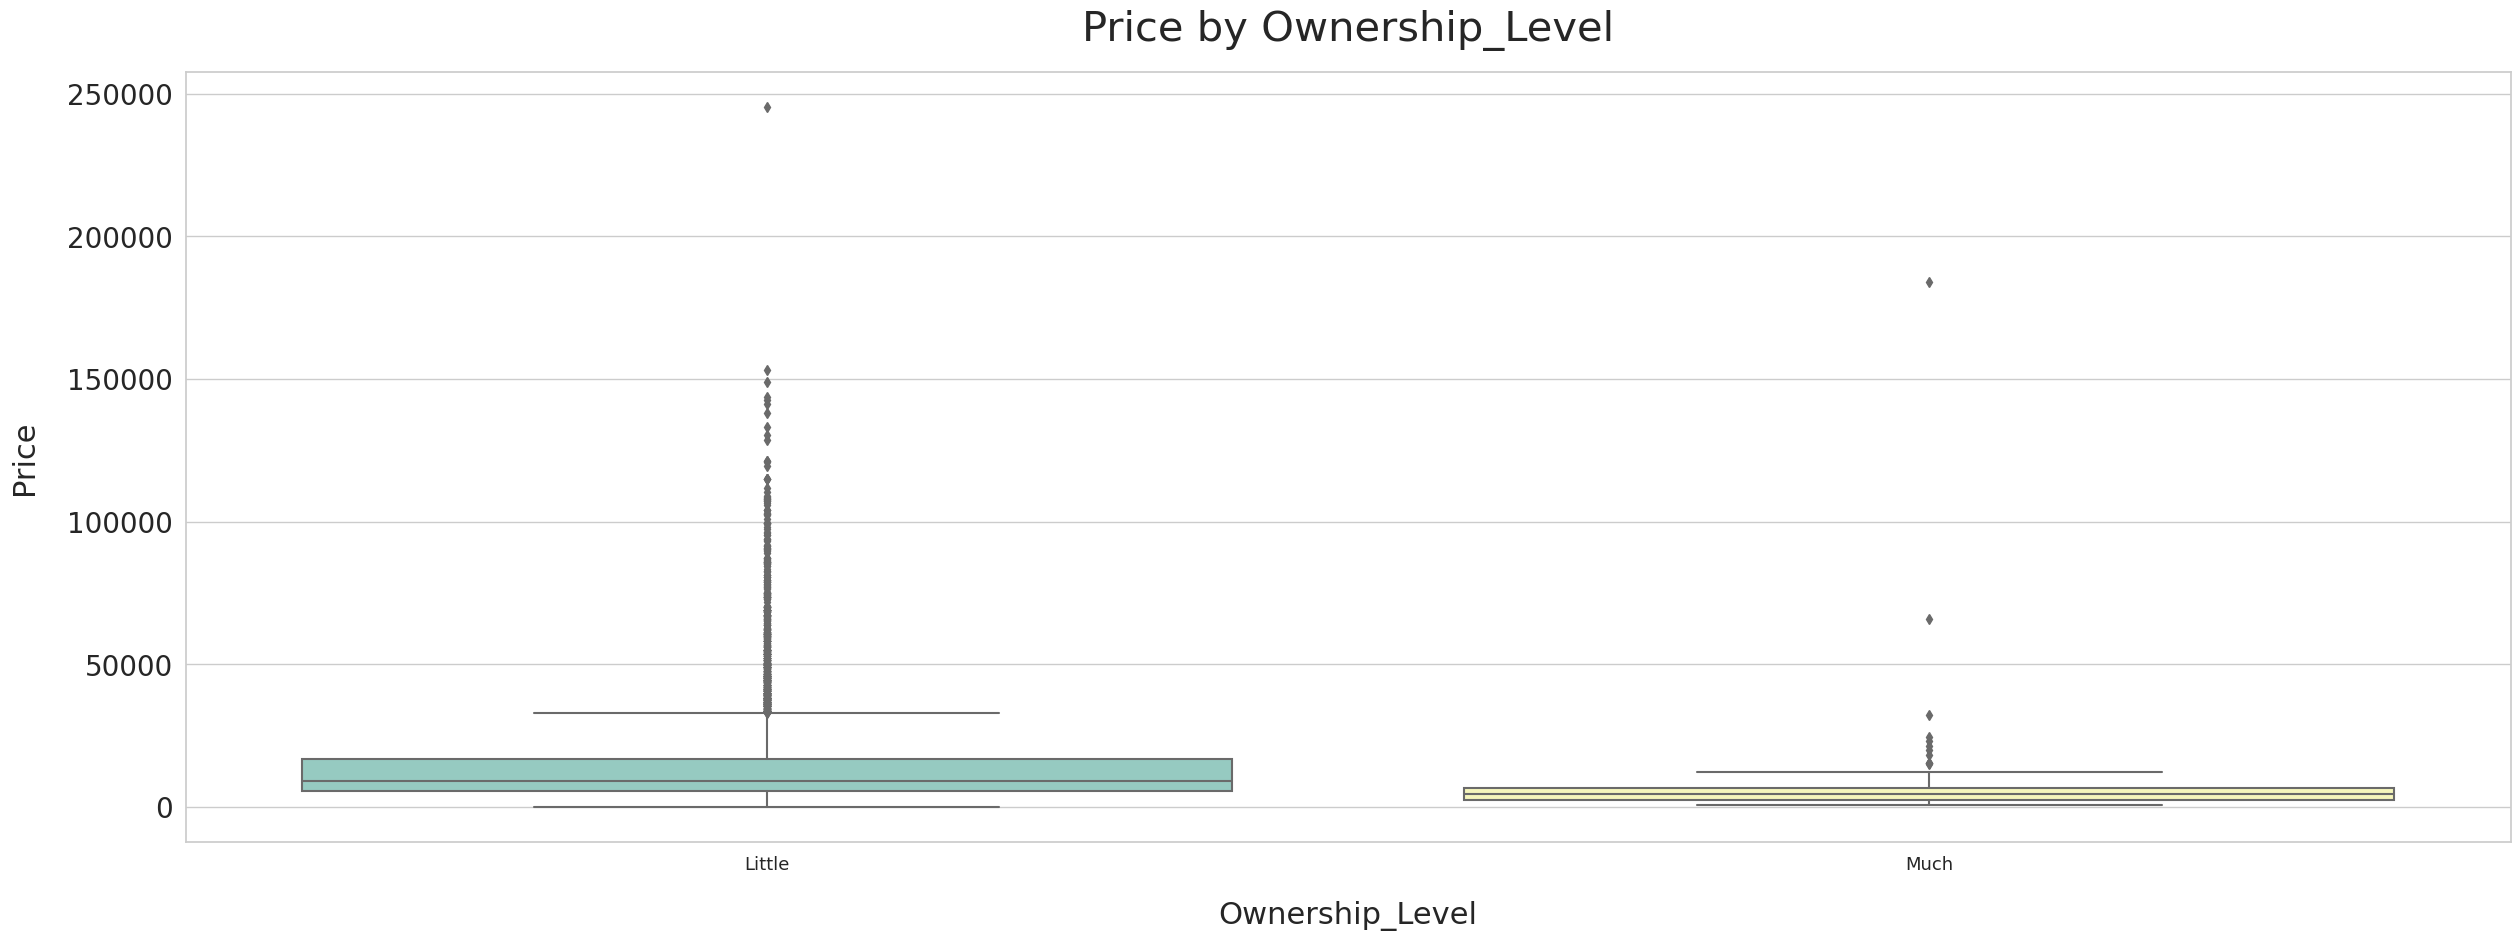

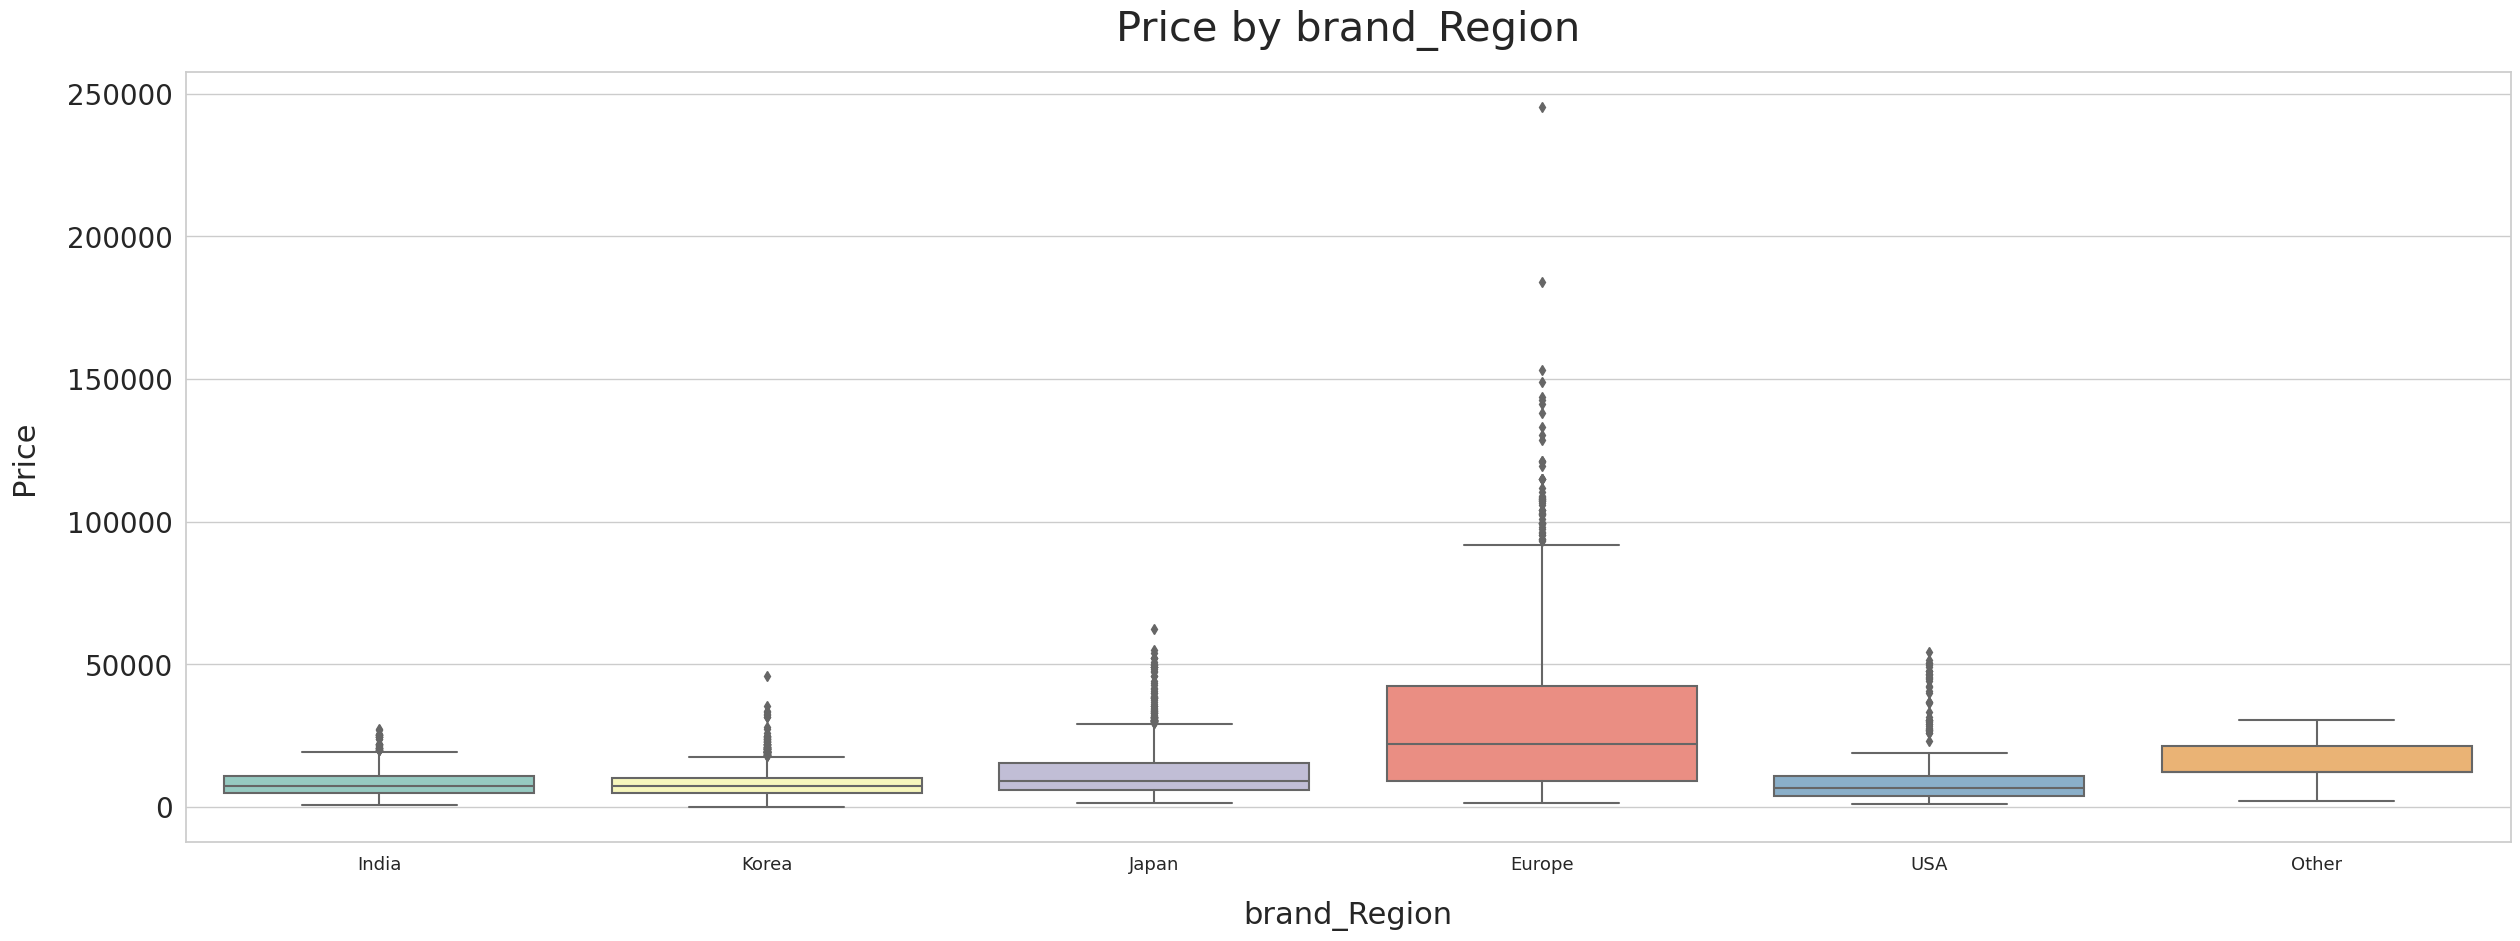

In [32]:
dummies = ["Fuel_Type", "Transmission", "Owner_Type", "Location_income", "Car_cate", "Brand_Category", "Ownership_Level", "brand_Region"]
for dum in dummies:
    plt.figure(figsize=(30,10))
    sns.set_theme(style="whitegrid")
    sns.boxplot(x=dum, y="Price", 
                data=df, palette="Set3")
    
    plt.title("Price by "+ dum, fontsize=30, y=1.03)
    
    plt.xticks(fontsize=13)
    plt.xlabel(dum, fontsize=22, labelpad=20)
    
    plt.yticks(fontsize=20)
    plt.ylabel("Price", fontsize=22, labelpad=20)
    
    plt.show()

- 가격값이 널값인 데이터와 아닌 데이터를 분리합니다.

In [33]:
df_mis_price = df[df['Price'].isna()]

df = df[df['Price'].notna()]

print(df_mis_price.shape)
print(df.shape)

(1006, 19)
(5972, 19)


# <span style="color:red"> 가설 수립 및 검정</span>

- 검정 및 분석을 진행하기전 연속형 변수들에 대해서 상관관계를 확인합니다.

<Axes: >

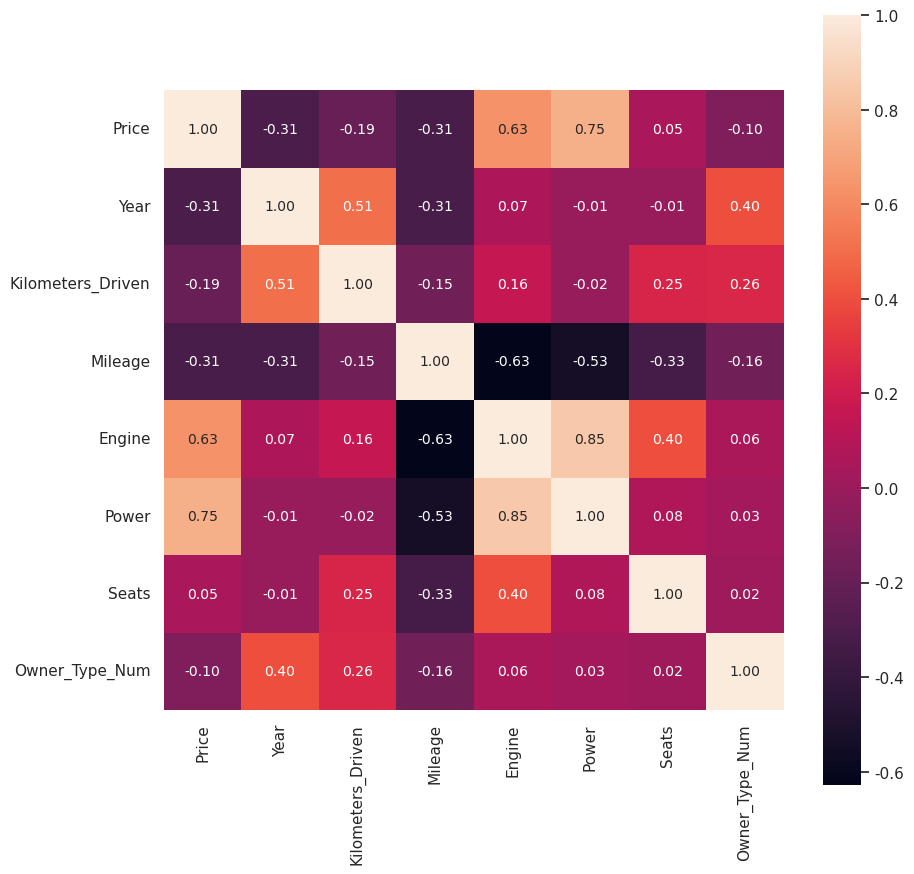

In [34]:
df_sel = df.select_dtypes(include=np.number)
plt.figure(figsize=(10, 10))
sns.heatmap(df_sel.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

In [35]:
df.corr().round(3)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Owner_Type_Num
Price,1.000,-0.307,-0.195,-0.310,0.631,0.749,0.047,-0.102
Year,-0.307,1.000,0.507,-0.310,0.067,-0.005,-0.009,0.399
Kilometers_Driven,-0.195,0.507,1.000,-0.152,0.164,-0.016,0.245,0.259
Mileage,-0.310,-0.310,-0.152,1.000,-0.628,-0.535,-0.334,-0.160
Engine,0.631,0.067,0.164,-0.628,1.000,0.850,0.397,0.056
Power,0.749,-0.005,-0.016,-0.535,0.850,1.000,0.083,0.028
Seats,0.047,-0.009,0.245,-0.334,0.397,0.083,1.000,0.016
Owner_Type_Num,-0.102,0.399,0.259,-0.160,0.056,0.028,0.016,1.000


- 귀무가설 : 지역 제조사별 중고차 가격 차이가 없다.
- 대립가설 : 지역 제조사별 중고차 가격 차이가 있다.

## ANOVA 분석

In [36]:
# ANOVA 분석
model = ols('Price ~ C(brand_Region)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA 결과:")
print(anova_table)

ANOVA 결과:
                       sum_sq      df           F  PR(>F)
C(brand_Region)  5.134503e+11     5.0  448.532492     0.0
Residual         1.365896e+12  5966.0         NaN     NaN


- P-value 값은 0.0으로 귀무가설을 기각할 수 있기에 지역 제조사별 중고차 가격에 차이가 있음을 알 수 있습니다. 
- 또한, F값이 507.237로 값이 매우 높기에 지역 제조사별 가격 차이는 상당하다는 것을 의미합니다.

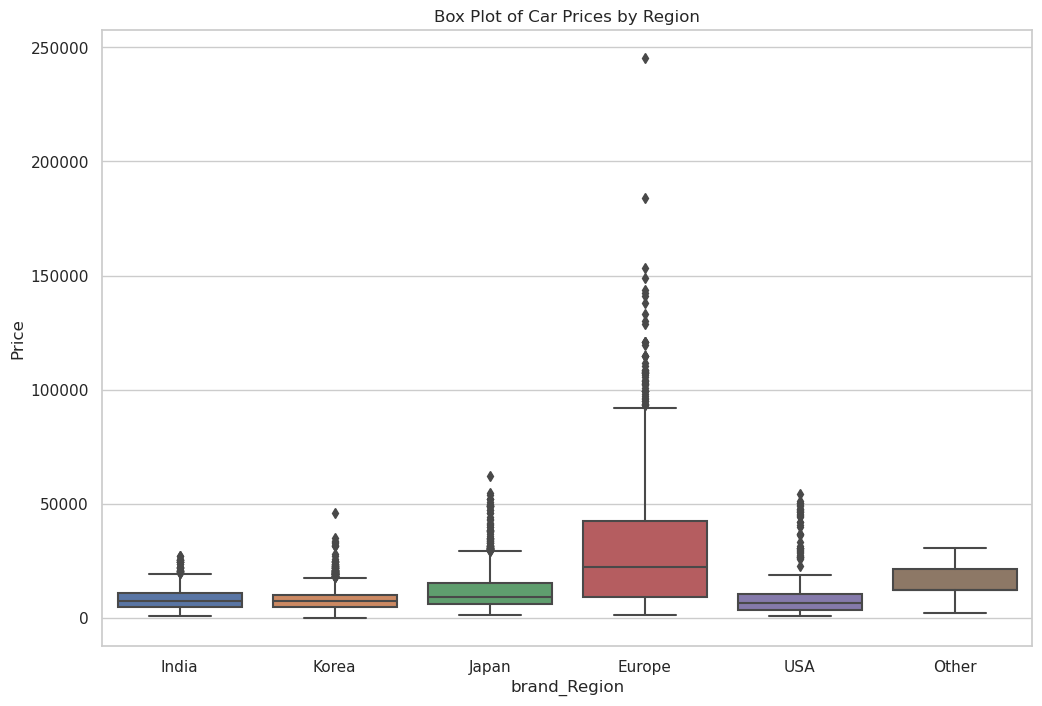

In [37]:
# 박스 플롯 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='brand_Region', y='Price', data=df)

# 제목과 라벨 설정
plt.title('Box Plot of Car Prices by Region')
plt.xlabel('brand_Region')
plt.ylabel('Price')

# 그래프 출력
plt.show()

 - box-plot 그래프를 보면 Europe 제조사 차량의 가격이 상당히 높은 것을 볼 수 있습니다. 이는 유럽의 고급 브랜드와 품질 유지, 차량의 역사적 가치 등이 영향을 미쳤을 것이라고 생각합니다.
 - 그 다음으로는 Japan, Usa 가격이 높게 측정 되었고, Korea, Other, India 순서임을 알 수 있습니다. 
 - 해당 지역의 시장 조건, 브랜드의 인지도에 따라 지역 제조사별 중고차의 가격에 차이가 있습니다.

## T 검정

- 귀무가설 : Owner_type의 (First, Second)와 (Third,Fourth&Above) 간 중고차 가격에 차이가 없다.
- 대립가설 :Owner_type의 (First, Second)와 (Third,Fourth&Above) 간 중고차 가격에 차이가 있다.

###### Owner_Type -> Little vs. Much

In [38]:
price_little = df[df['Ownership_Level'] == 'Little']['Price']
price_much = df[df['Ownership_Level'] == 'Much']['Price']

In [39]:
# T-검정 수행
t_stat, p_value = stats.ttest_ind(price_little, price_much, equal_var=False)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 4.3313
P-Value: 0.0000


- t 통계량 값 4.3313이고 P-value 값이 0.000으로 귀무가설을 기각할 수 있기에 Litte(Fisrt, Second)와 Much(Third, Fourth&Above) 두 그룹 간 중고차 평균 가격 차이는 통계적으로 유의미하다고 결론을 내릴 수 있습니다.

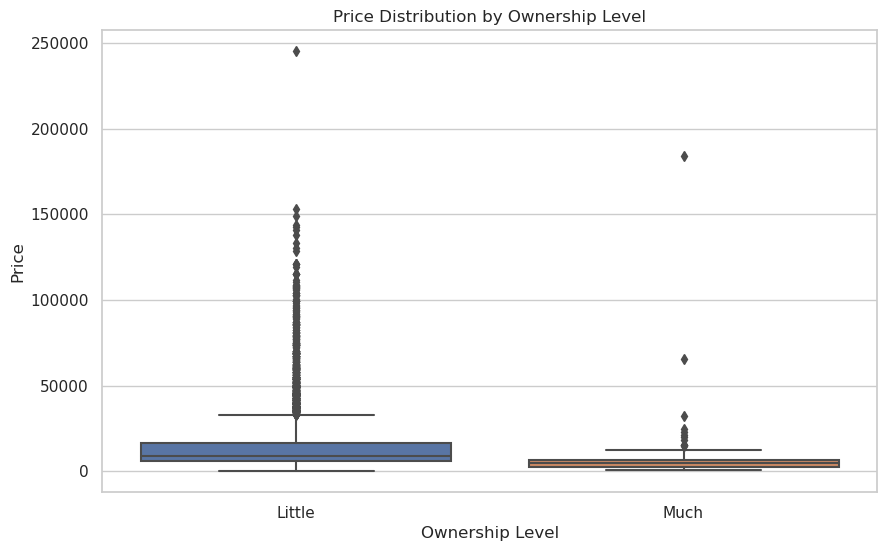

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ownership_Level', y='Price', data=df)

# 그래프 제목과 레이블 설정
plt.title('Price Distribution by Ownership Level')
plt.xlabel('Ownership Level')
plt.ylabel('Price')

# 그래프 출력
plt.show()

In [41]:
manual_group = df[df['Transmission'] == 'Manual']['Price']
automatic_group = df[df['Transmission'] == 'Automatic']['Price']

# t-검정 수행
t_stat, p_value = stats.ttest_ind(manual_group, automatic_group, equal_var=False)


# 결과 출력
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: -37.0963
P-Value: 0.0000


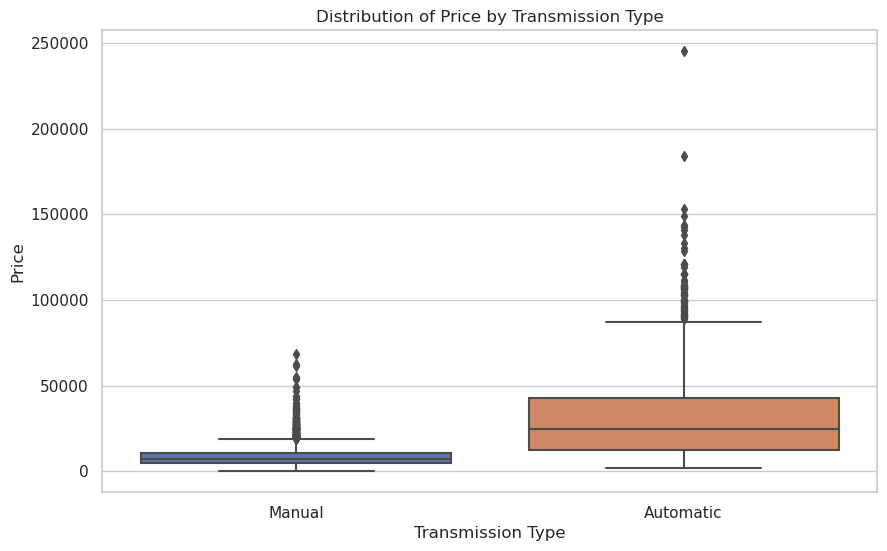

In [42]:
# 그래프
plt.figure(figsize=(10, 6))
sns.boxplot(x='Transmission', y='Price', data=df)  # 'Price'를 실제 변수명으로 수정

plt.title('Distribution of Price by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Price')
plt.show()

- T-Statistic: -37.0963 \
  => Manual 그룹의 평균 가격이 Automatic 그룹보다 낮습니다. \
  => 그룹 간 평균 가격의 차이가 매우 큽니다.

- Fuel_Type -> Diesel vs. Petrol

In [43]:
#t
fuel_df = df[df['Fuel_Type'].isin(['Diesel', 'Petrol'])]

diesel_group = fuel_df[fuel_df['Fuel_Type'] == 'Diesel']['Price']
petrol_group = fuel_df[fuel_df['Fuel_Type'] == 'Petrol']['Price']

# t-검정 수행
t_stat, p_value = stats.ttest_ind(diesel_group, petrol_group, equal_var=False)


# 결과 출력
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

T-Statistic: 25.1415
P-Value: 0.0000


- T-Statistic: 25.1415
=> 'Diesel' 그룹의 평균 가격이 Petrol 그룹보다 낮음.
=> 평균 가격 차이 매우 큼.

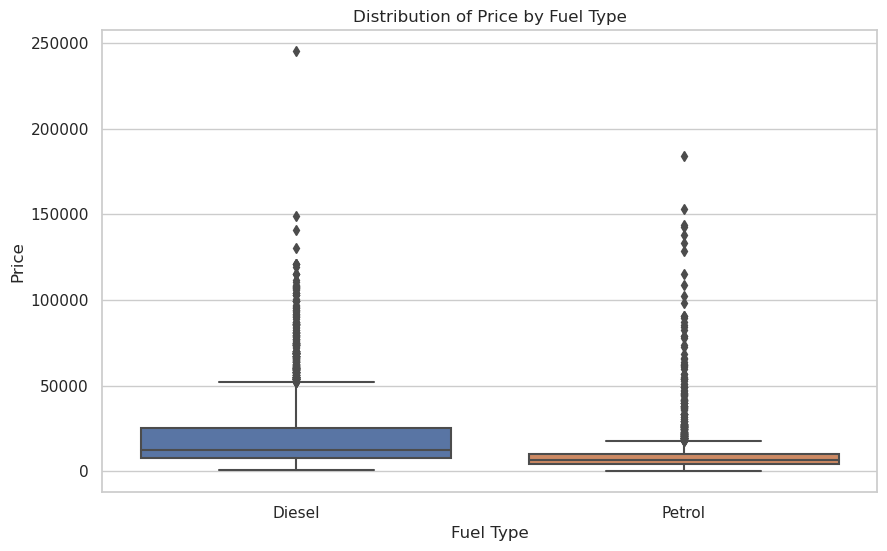

In [44]:
# 그래프
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel_Type', y='Price', data=fuel_df)  # 'Price'를 실제 변수명으로 수정

plt.title('Distribution of Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.show()

## 카이제곱 검정

In [45]:
cross_tab = pd.crosstab(df['Brand_Category'], df['Location_income'])

chi2_stat, p_value, dof, expected = chi2_contingency(cross_tab)

# 결과 출력
print(f"카이제곱 통계량: {chi2_stat}")
print(f"P-value(유의확률): {p_value}")
print(f"자유도: {dof}")
print("기대 빈도:\n", expected)

카이제곱 통계량: 22.20852423486667
P-value(유의확률): 0.004543875426460422
자유도: 8
기대 빈도:
 [[2.57635633e+00 1.22019424e+00 3.20344943e+00]
 [7.10338245e+02 3.36424983e+02 8.83236772e+02]
 [3.29773610e+02 1.56184863e+02 4.10041527e+02]
 [1.11519424e+03 5.28169792e+02 1.38663597e+03]
 [4.01175486e+01 1.90001674e+01 4.98822840e+01]]


- p-value값이 0.05보다 작으므로 귀무가설을 기각합니다. 즉, 특정 소득 수준(Location_income)에 따라 특정 브랜드 카테고리의 중고차 비율이 달라질 가능성이 있으며, 두 변수 사이에 통계적으로 유의미한 관계가 있다고 볼 수 있습니다.

In [46]:
#귀무가설 : 관측된 빈도가 기대되는 빈도와 차이가 없다.-> 
# 대립 : 관측된 빈도가 기대되는 빈도와 차이가 있다.

cross_tab = pd.crosstab(df['Brand_Category'], df['Location_income'])

# 카이제곱 검정 수행
chi2_stat, p_value, dof, expected = chi2_contingency(cross_tab)

# 실제 빈도와 기대 빈도의 차이 계산
difference = cross_tab - expected

# 결과 출력
print(f"카이제곱 통계량: {chi2_stat}")
print(f"P-value(유의확률): {p_value}")
print(f"자유도: {dof}")
print("기대 빈도:\n", pd.DataFrame(expected, index=cross_tab.index, columns=cross_tab.columns))
print("실제 빈도와 기대 빈도의 차이:\n", difference)

카이제곱 통계량: 22.20852423486667
P-value(유의확률): 0.004543875426460422
자유도: 8
기대 빈도:
 Location_income            High         Low       Median
Brand_Category                                          
Commercial/Utility     2.576356    1.220194     3.203449
Economy              710.338245  336.424983   883.236772
Luxury               329.773610  156.184863   410.041527
Mainstream          1115.194240  528.169792  1386.635968
Premium               40.117549   19.000167    49.882284
실제 빈도와 기대 빈도의 차이:
 Location_income          High        Low     Median
Brand_Category                                     
Commercial/Utility  -0.576356   0.779806  -0.203449
Economy            -49.338245  22.575017  26.763228
Luxury              48.226390 -34.184863 -14.041527
Mainstream          -1.194240   9.830208  -8.635968
Premium              2.882451   0.999833  -3.882284


- p-value가 0.05이하이므로 귀무가설을 기각합니다.결국, 이는 소득 수준에 따라 사람들이 선호하는 중고차 브랜드가 달라질 수 있음을 시사하고, 이는 특정 소득 수준에서 특정 브랜드의 중고차가 더 많이 판매될 수 있다고 볼 수 있습니다.

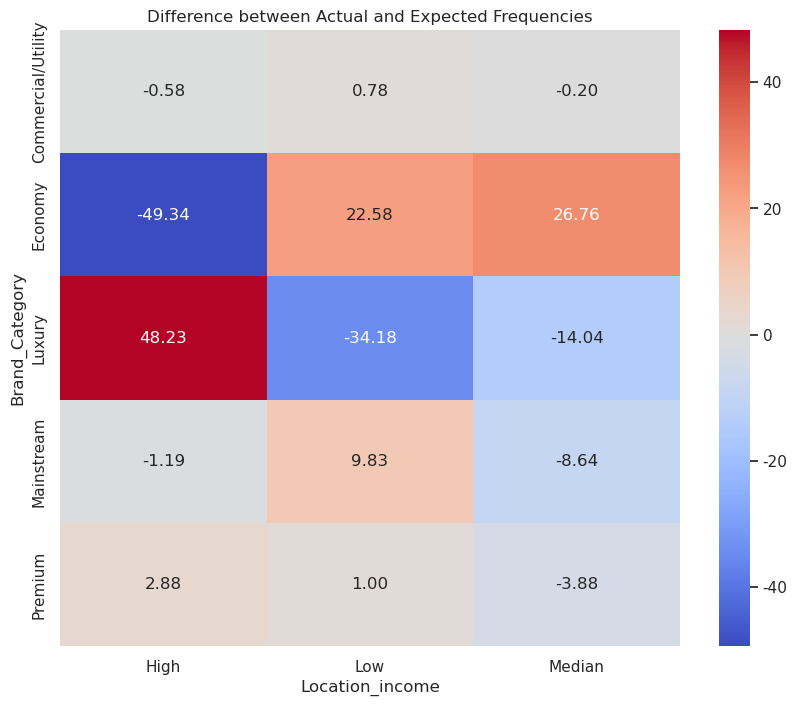

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(difference, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Difference between Actual and Expected Frequencies')
plt.show()

> 양의 값 : 실제 빈도가 기대 빈도보다 높음을 나타내고 이는 특정 브랜드의 특정소득 범위에서 실제 판매량이 기대보다 많다면 이 브랜드가 그 소득 범위에서 예상보다 더 많은 인기를 끌고 있음을 의미한다고 볼 수 있습니다.

> 음의 값 : 실제 빈도가 기대 빈도보다 낮음을 나타내고 만약 특정 브랜드의 특정 소득 범위에서 실제 판매량이 기대보다 적다면, 이 브랜드가 그 소득 범위에서 예상보다 덜 인기 있음을 의미한다고 볼 수 있습니다.

# <span style="color:red"> 모델링 및 평가 </span>

(array([2.600e+03, 1.873e+03, 5.170e+02, 2.970e+02, 2.030e+02, 1.510e+02,
        1.020e+02, 6.000e+01, 5.400e+01, 3.100e+01, 2.200e+01, 1.800e+01,
        1.400e+01, 1.100e+01, 8.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([7.08000000e+00, 8.18263067e+03, 1.63581813e+04, 2.45337320e+04,
        3.27092827e+04, 4.08848333e+04, 4.90603840e+04, 5.72359347e+04,
        6.54114853e+04, 7.35870360e+04, 8.17625867e+04, 8.99381373e+04,
        9.81136880e+04, 1.06289239e+05, 1.14464789e+05, 1.22640340e+05,
        1.30815891e+05, 1.38991441e+05, 1.47166992e+05, 1.55342543e+05,
        1.63518093e+05, 1.71693644e+05, 1.79869195e+05, 1.88044745e+05,
        1.96220296e+05, 2.04395847e+05, 2.12571397e+05, 2.20746948e+05,
        2.28922499e+05, 2.37098049e+05, 2.45273600e+05]),
 <BarContainer object of 30 artists>)

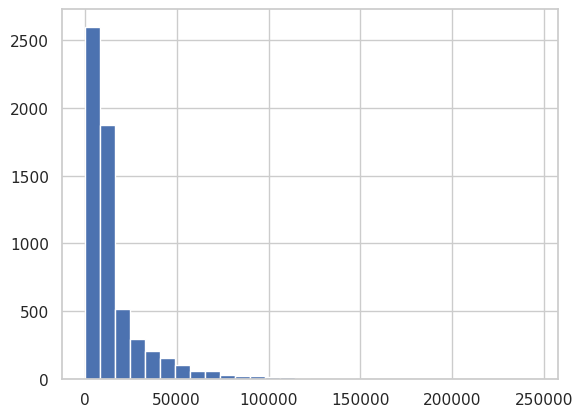

In [48]:
plt.hist(df['Price'],bins = 30)

- 타겟값인 가격값의 분포를 로그변환하여 정규화를 어느정도 진행해줍니다.

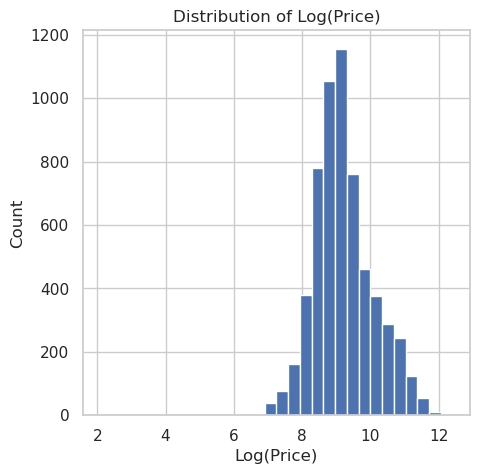

In [49]:
df['Price_log'] = np.log1p(df['Price'])

plt.figure(figsize=(5, 5))
plt.hist(df['Price_log'], bins=30)
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.title('Distribution of Log(Price)')
plt.show()

- 정규화를 확인하기위해 샤피로 검정과 Q-Q Plot를 생성합니다. p-value가 0.05보다 낮기 때문에 정규화가 유의하지않습니다\

- 하지만 통계량이 1에 가까울수록 정규성을 띈다는 점, Q-Q Plot이 어느정도 직선에 겹치게 분포한다는 것을 확인해주는 것으로 price 값이 정규성을 띈다고 가정하였습니다

In [50]:
stat, p = shapiro(df['Price_log'])
print('Shapiro-Wilk test 결과 - Statistic: {}, p-value: {}'.format(stat, p))

Shapiro-Wilk test 결과 - Statistic: 0.9784094095230103, p-value: 3.5546771622199226e-29


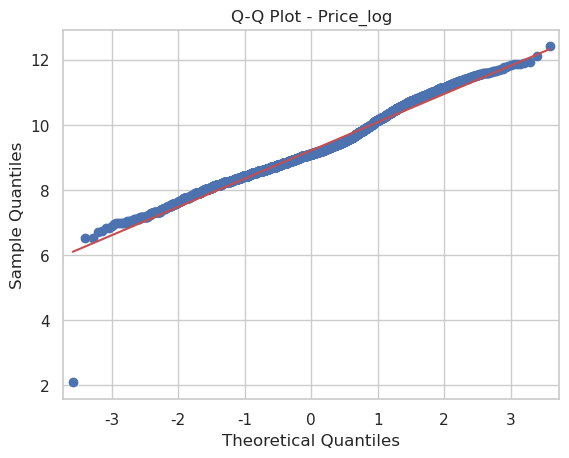

In [51]:
sm.qqplot(df['Price_log'], line='s')
plt.title('Q-Q Plot - Price_log')
plt.show()

Text(0.5, 1.0, 'Year')

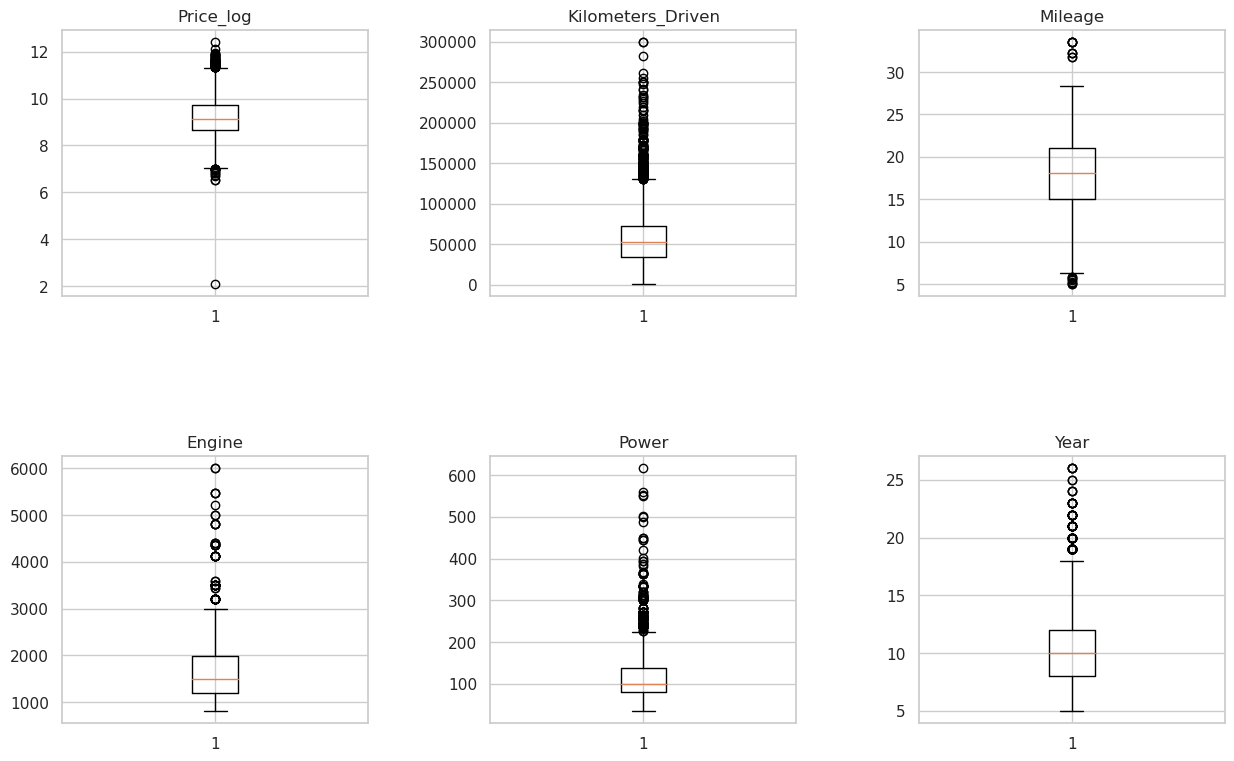

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(15, 9))
axs = axs.flatten()

fig.subplots_adjust(wspace=0.4, hspace=0.6)

axs[0].boxplot(df['Price_log'])
axs[0].set_title('Price_log')

axs[1].boxplot(df['Kilometers_Driven'])
axs[1].set_title('Kilometers_Driven')

axs[2].boxplot(df['Mileage'])
axs[2].set_title('Mileage')

axs[3].boxplot(df['Engine'])
axs[3].set_title('Engine')

axs[4].boxplot(df['Power'])
axs[4].set_title('Power')

axs[5].boxplot(df['Year'])
axs[5].set_title('Year')

- 가격값을 로그조정한 후 이상치가 일부 발견되어 제거해주었습니다.

In [53]:
df.drop(df[df['Price_log'] < 3].index, inplace=True)

- 원핫 인코딩 전 의미가 없는 변수들을 제거합니다.

In [54]:
df.drop(labels = 'Location', axis = 1, inplace = True)
df.drop(labels = 'Name', axis = 1, inplace = True)
df.drop(labels = 'Seats', axis = 1, inplace = True)
df.drop(labels = 'Brand', axis = 1, inplace = True)
df.drop(labels = 'Price', axis = 1, inplace = True)

- 다중선형회귀 분석을 하기전 연속형 : 표준화, 범주형 : 원핫 인코딩 을 진행합니다.

In [55]:
df_char=df.select_dtypes(include="object")
df_numeric=df.select_dtypes(exclude="object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)
df_encoded = pd.get_dummies(df_char, drop_first=True)

df_final = df_numeric_scaled.join(df_encoded)

- 학습 및 평가 데이터도 나눠줍니다.

In [56]:
df_train, df_test = train_test_split(df_final, test_size = 0.3, random_state = 1234) 
print('train data size : {}'.format(df_train.shape)) 
print('test data size : {}'.format(df_test.shape))

train data size : (4179, 31)
test data size : (1792, 31)


- 연속형 데이터에 대해서 다중회귀분석을 진행합니다.

In [57]:
reg_model = smf.ols(
    formula='Price_log ~ Power + Kilometers_Driven + Mileage + Engine + Year', 
    data=df_train
)

reg_result = reg_model.fit()

print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3246.
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:08:33   Log-Likelihood:                -2615.1
No. Observations:                4179   AIC:                             5242.
Df Residuals:                    4173   BIC:                             5280.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0072      0.00

- VIF 계수를 확인하여 다중공선성도 고려해줍니다

In [58]:
df_train_x = df_final[['Power', 'Kilometers_Driven', 'Mileage', 'Engine', 'Year']]

# 상수 항 추가
df_train_x_const = add_constant(df_train_x)

# VIF 계산
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

# VIF 결과 출력
print(df_vif.sort_values('VIF', ascending=True).round(2))

            variable   VIF
0              const  1.00
2  Kilometers_Driven  1.52
5               Year  1.55
3            Mileage  1.91
1              Power  3.96
4             Engine  4.80


In [59]:
reg_model1 = smf.ols(
    formula='Price_log ~ Power + Mileage + Engine + Year', 
    data=df_train
)

reg_result1 = reg_model1.fit()

print(reg_result1.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     4058.
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:08:33   Log-Likelihood:                -2615.3
No. Observations:                4179   AIC:                             5241.
Df Residuals:                    4174   BIC:                             5272.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0072      0.007     -1.026      0.3

In [60]:
df_train_x = df_final[['Power', 'Mileage', 'Engine', 'Year']]

# 상수 항 추가
df_train_x_const = add_constant(df_train_x)

# VIF 계산
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

# VIF 결과 출력
print(df_vif.sort_values('VIF', ascending=True).round(2))

  variable   VIF
0    const  1.00
4     Year  1.16
2  Mileage  1.88
1    Power  3.66
3   Engine  4.25


- 유의한 피처들만 남기고 VIF 값을 확인해줍니다.(최종모델)

In [61]:
reg_model2 = smf.ols(
    formula='Price_log ~ Power + Engine + Year', 
    data=df_train
)

reg_result2 = reg_model2.fit()

print(reg_result2.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_log   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     5411.
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:08:33   Log-Likelihood:                -2615.4
No. Observations:                4179   AIC:                             5239.
Df Residuals:                    4175   BIC:                             5264.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0072      0.007     -1.024      0.3

- 등분산성 및 정규성, 독립성을 확인합니다.

- 등분산성 및 정규성 같은 경우 타겟값을 로그변환 해줬음에도 불구하고 만족스러운 결과가 도출되지 않았습니다. Box-cox 기법을 이용하는 등의 개선이 필요하다고 생각합니다.

- 등분산성 : 불만족

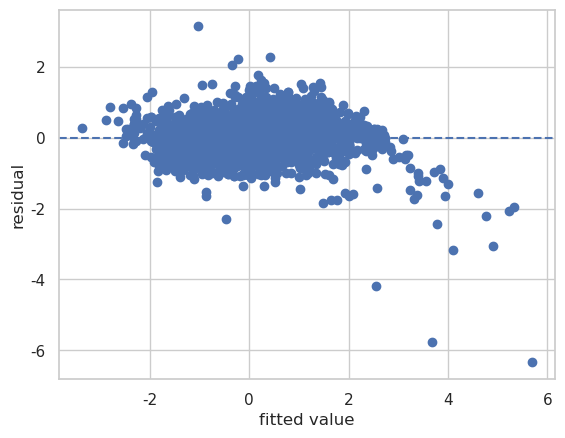

In [62]:
plt.scatter(reg_result2.fittedvalues, reg_result2.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = "--")

- 정규성 : 불만족

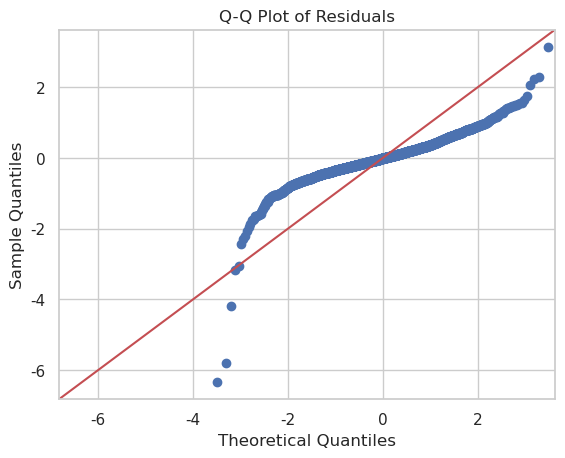

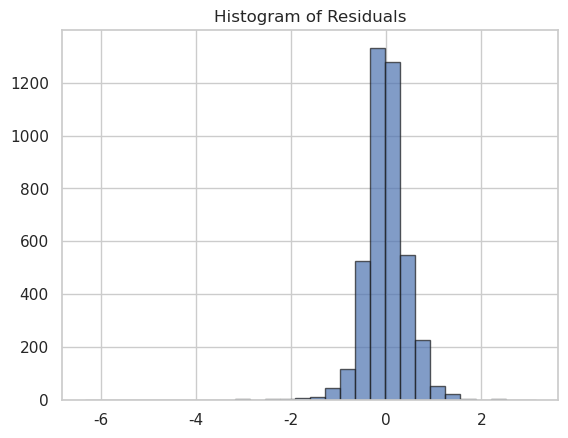

In [63]:
residuals = reg_result2.resid
# Q-Q 플롯
sm.qqplot(residuals, line ='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# 잔차 히스토그램
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.show()

- 독립성 : 불만족 > 일부 최고급 및 특수목적의 차량의 값이 독립성 검정에서 이상치로 발생된다고 생각합니다.

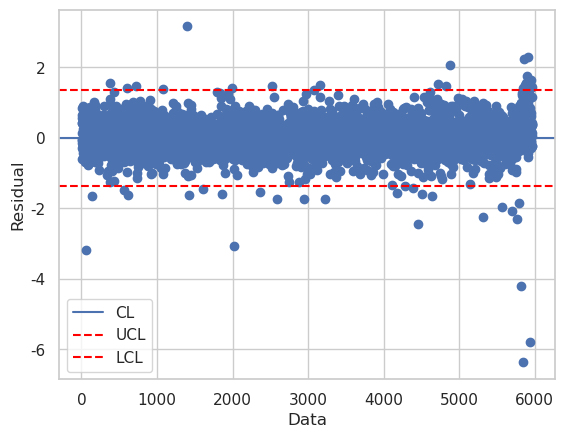

In [64]:
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")  ;  plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-", label='CL')
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label='UCL' )
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label='LCL')
plt.legend()

In [65]:
df_train_x = df_final[['Power', 'Engine', 'Year']]

# 상수 항 추가
df_train_x_const = add_constant(df_train_x)

# VIF 계산
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]

# VIF 결과 출력
print(df_vif.sort_values('VIF', ascending=True).round(2))

  variable   VIF
0    const  1.00
3     Year  1.02
1    Power  3.65
2   Engine  3.67


- 회귀계수들을 출력하여 최종 회귀식을 도출합니다.

<Axes: >

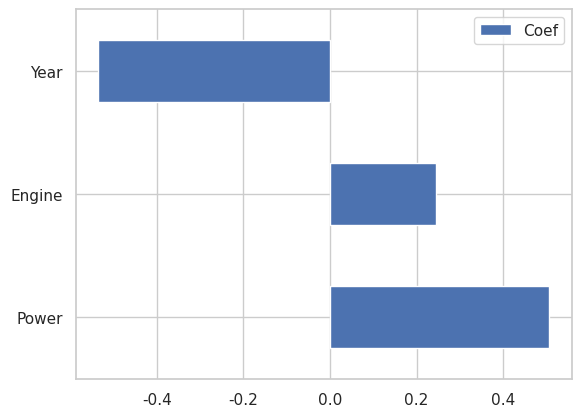

In [66]:
df_reg_coef = pd.DataFrame({"Coef": reg_result2.params.values[1:]},  
                           index = ['Power','Engine','Year'])
df_reg_coef.plot.barh(y = "Coef")

In [67]:
intercept = reg_result2.params[0]  # 절편
coefficients = reg_result2.params[1:]  # 피처의 회귀 계수
feature_names = ['Power', 'Engine', 'Year']  # 피처 이름 (절편 제외)

# 회귀식 문자열 생성
equation = f"y = {intercept:.2f}"
for name, coef in zip(feature_names, coefficients):
    if coef >= 0:
        equation += f" + {coef:.2f} * x ({name})"
    else:
        equation += f" - {abs(coef):.2f} * x({name})"

print("회귀식:")
print(equation)

회귀식:
y = -0.01 + 0.51 * x (Power) + 0.24 * x (Engine) - 0.53 * x(Year)


### 회귀식: y = -0.01 + 0.51 * x1 (Power) + 0.24 * x2 (Engine) - 0.53 * x3 (Year)

- 회귀식의 성능을 확인합니다.

In [68]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print('train data 의 결정계수:', r2_score(df_train['Price_log'],train_pred))
print('test data의 결정계수:', r2_score(df_test['Price_log'], test_pred))

train data 의 결정계수: 0.7954637145337892
test data의 결정계수: 0.8054858298234797


- 트리계열의 회귀모델은 표준화가 필요없습니다. 원핫인코딩만 진행합니다.

In [69]:
df_onehot = pd.get_dummies(df)

- 학습이 가능한 형태로 전처리합니다.

In [70]:
df_x = df_onehot.drop("Price_log", axis = 1, inplace = False)
df_y = df_onehot["Price_log"] 

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=13)
v_feature_name = X_train.columns

- GridsearchCV 기능을 이용하여 최적 하이퍼파라미터를 도출합니다.

In [72]:
# param_grid = {
#         'max_depth': [i for i in range(1,7)],
#         'min_samples_split': [i*10 for i in range(3,8)],
#         'min_samples_leaf': [i*5 for i in range(2,5)]}

# dt_reg = DecisionTreeRegressor()
# grid_search = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_dt_reg = grid_search.best_estimator_
# best_params = best_dt_reg.get_params()
# print("Best Hyperparameters:", best_params)

In [73]:
# param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [i for i in range(1,7)],
#         'min_samples_split': [i*10 for i in range(3,8)],
#         'min_samples_leaf': [i*5 for i in range(2,5)]}

# rf_reg = RandomForestRegressor(random_state=1234)
# grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_rf_reg = grid_search.best_estimator_
# best_params = best_rf_reg.get_params()
# print("Best Hyperparameters:", best_params)

In [74]:
# param_grid = {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#         'max_depth': [i for i in range(1,7)],
#         'min_samples_split': [i*10 for i in range(3,8)],
#         'min_samples_leaf': [i*5 for i in range(2,5)]}

# gb_reg = GradientBoostingRegressor(random_state=1234)
# grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)
# best_gb_reg = grid_search.best_estimator_
# best_params = best_gb_reg.get_params()
# print("Best Hyperparameters:", best_params)

- 최적의 하이퍼 파라미터를 이용하여 모델을 학습시키고 실제값과 모델의 예측 정확도 및 평가지표를 확인합니다.
- 추가적으로 피처들의 중요도를 확인합니다.

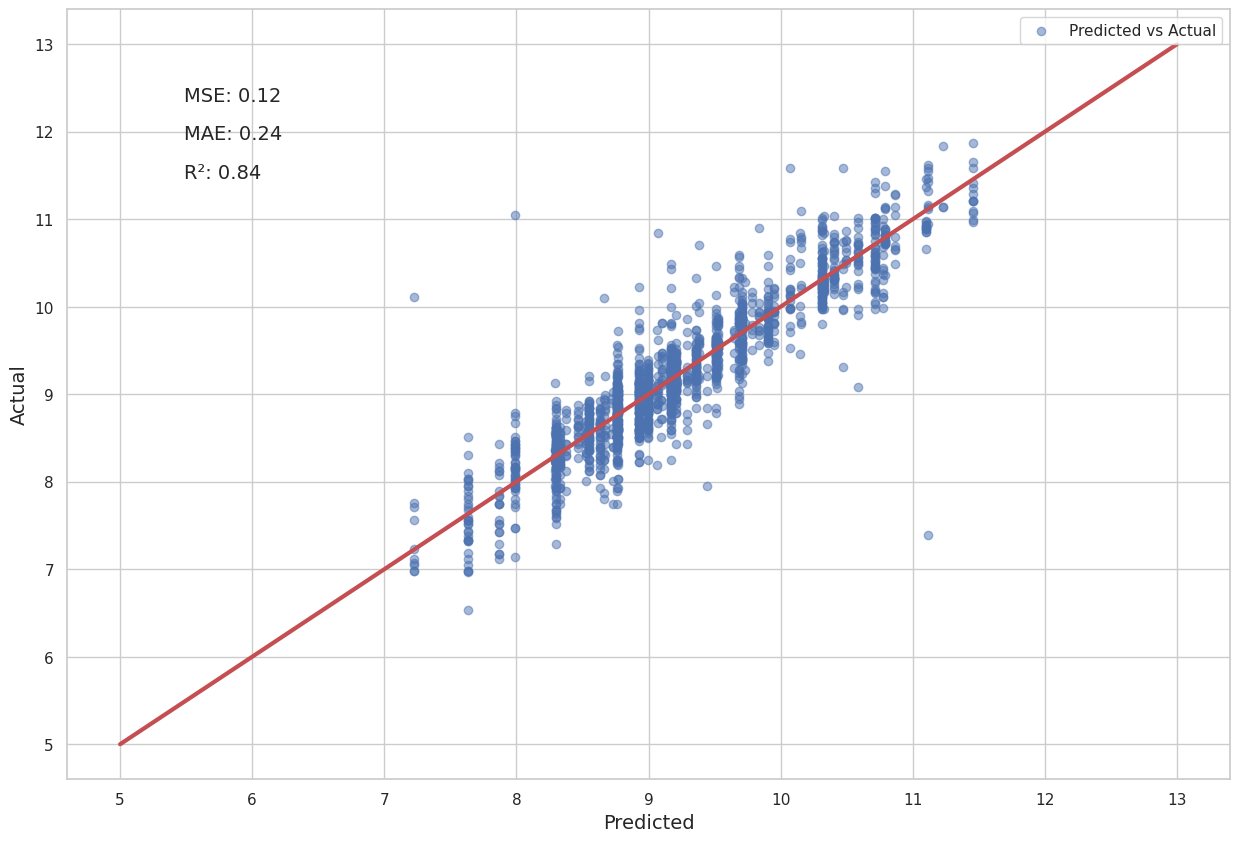

In [75]:
dt_reg = DecisionTreeRegressor(ccp_alpha = 0.0, criterion = 'squared_error', max_depth = 6, max_features = None, \
                            max_leaf_nodes = None, min_impurity_decrease = 0.0, min_samples_leaf = 10, min_samples_split = 30, \
                            min_weight_fraction_leaf = 0.0, random_state = None, splitter = 'best')
dt_reg.fit(X_train, y_train)

predicted = dt_reg.predict(X_test)
actual = y_test

act_df = pd.DataFrame(actual)
pred_df = pd.DataFrame(predicted)

act_df.reset_index(inplace=True)

act_pred_df = pd.concat([act_df, pred_df], axis=1)
act_pred_df.columns = ['index', 'actual', 'predicted']

    # 성능 지표 계산
mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)
    # 그래프 생성
plt.figure(figsize=(15, 10))
plt.scatter(act_pred_df['predicted'], act_pred_df['actual'], alpha=0.5, label='Predicted vs Actual')

    # 성능 지표를 텍스트로 그래프에 추가
plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
line = plt.plot([5, 13], [5, 13], color='r', linewidth=3.0)
plt.legend()
plt.show()

Text(0, 0.5, 'Feature')

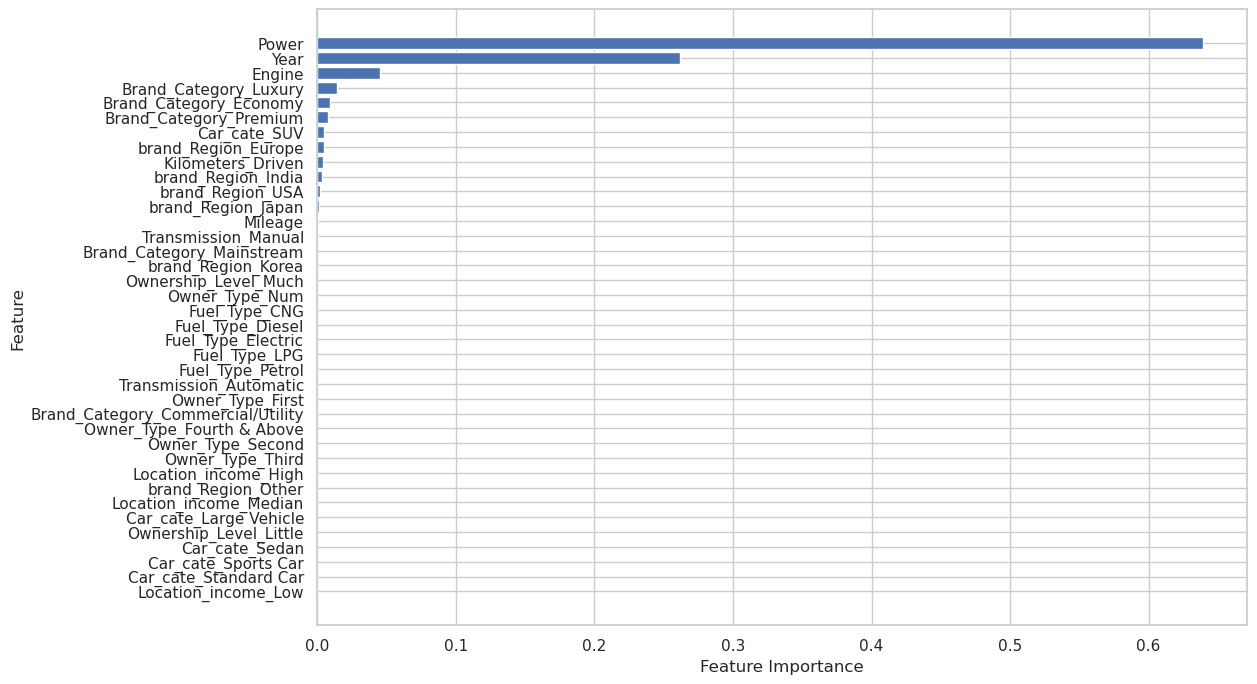

In [76]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = dt_reg.feature_importances_

df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12, 8))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

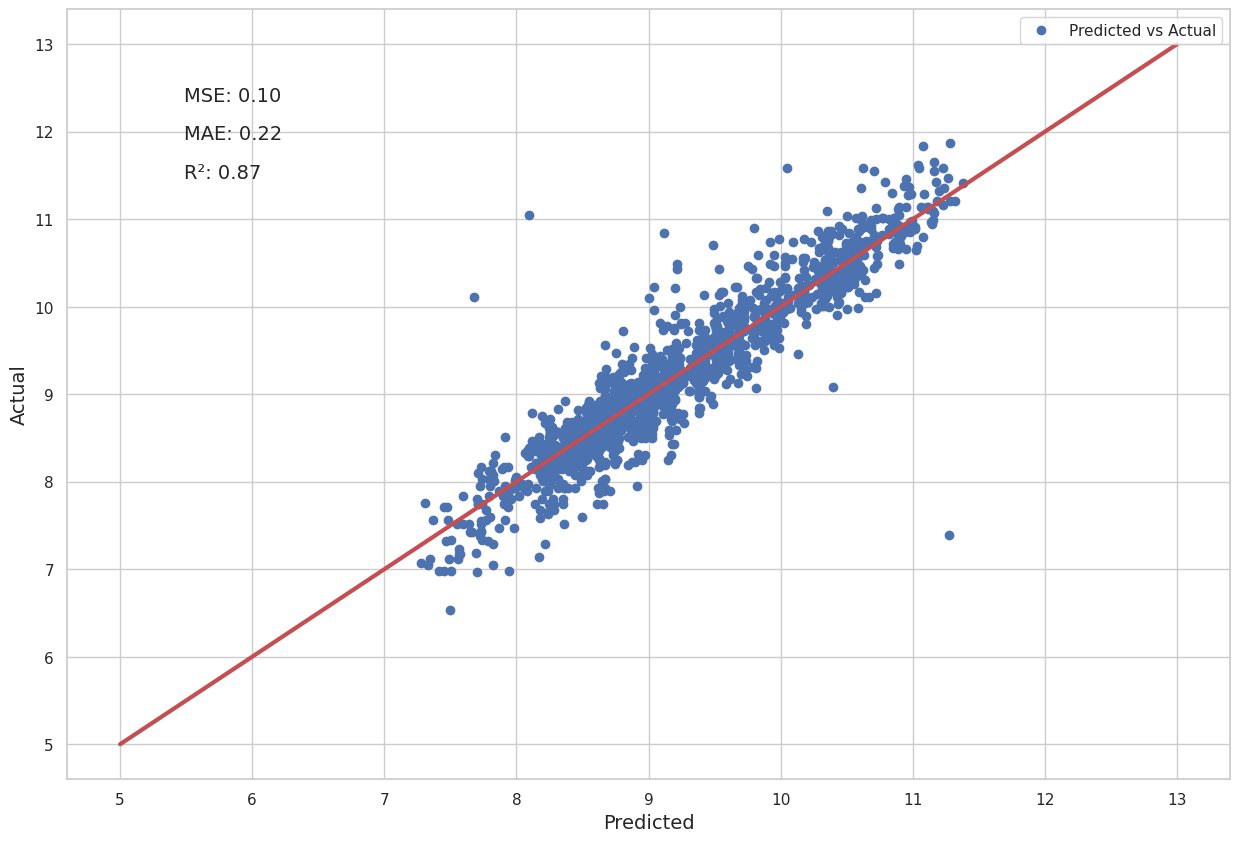

In [77]:
rf_reg = RandomForestRegressor(bootstrap = True, ccp_alpha = 0.0, criterion = 'squared_error', max_depth = 6,\
                                max_features = 1.0, max_leaf_nodes = None, max_samples = None, \
                                min_impurity_decrease = 0.0, min_samples_leaf = 10, min_samples_split = 30,\
                                min_weight_fraction_leaf = 0.0, n_estimators = 200, n_jobs = None, oob_score = False,\
                                random_state = 1234, verbose = 0, warm_start = False)
rf_reg.fit(X_train, y_train)

predicted = rf_reg.predict(X_test)
actual = y_test

act_df = pd.DataFrame(actual)
pred_df = pd.DataFrame(predicted)

act_df.reset_index(inplace=True)

act_pred_df = pd.concat([act_df, pred_df], axis=1)
act_pred_df.columns = ['index', 'actual', 'predicted']

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

plt.figure(figsize=(15, 10))
plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
line = plt.plot([5, 13], [5, 13], color='r', linewidth=3.0)
plt.legend()
plt.show()

Text(0, 0.5, 'Feature')

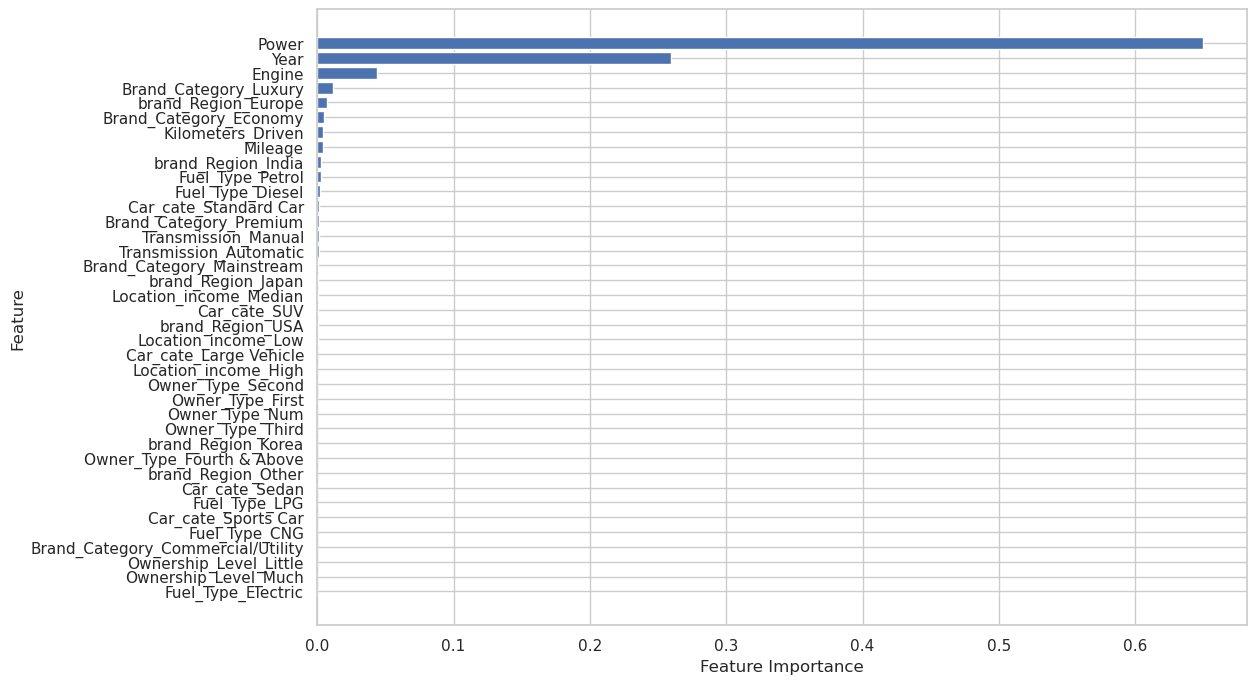

In [78]:
rf_importance = pd.DataFrame()
rf_importance['Feature'] = v_feature_name
rf_importance['Importance'] = rf_reg.feature_importances_

rf_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(rf_importance))
plt.figure(figsize=(12, 8))
plt.barh(y = coordinates, width = rf_importance['Importance'])
plt.yticks(coordinates, rf_importance['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

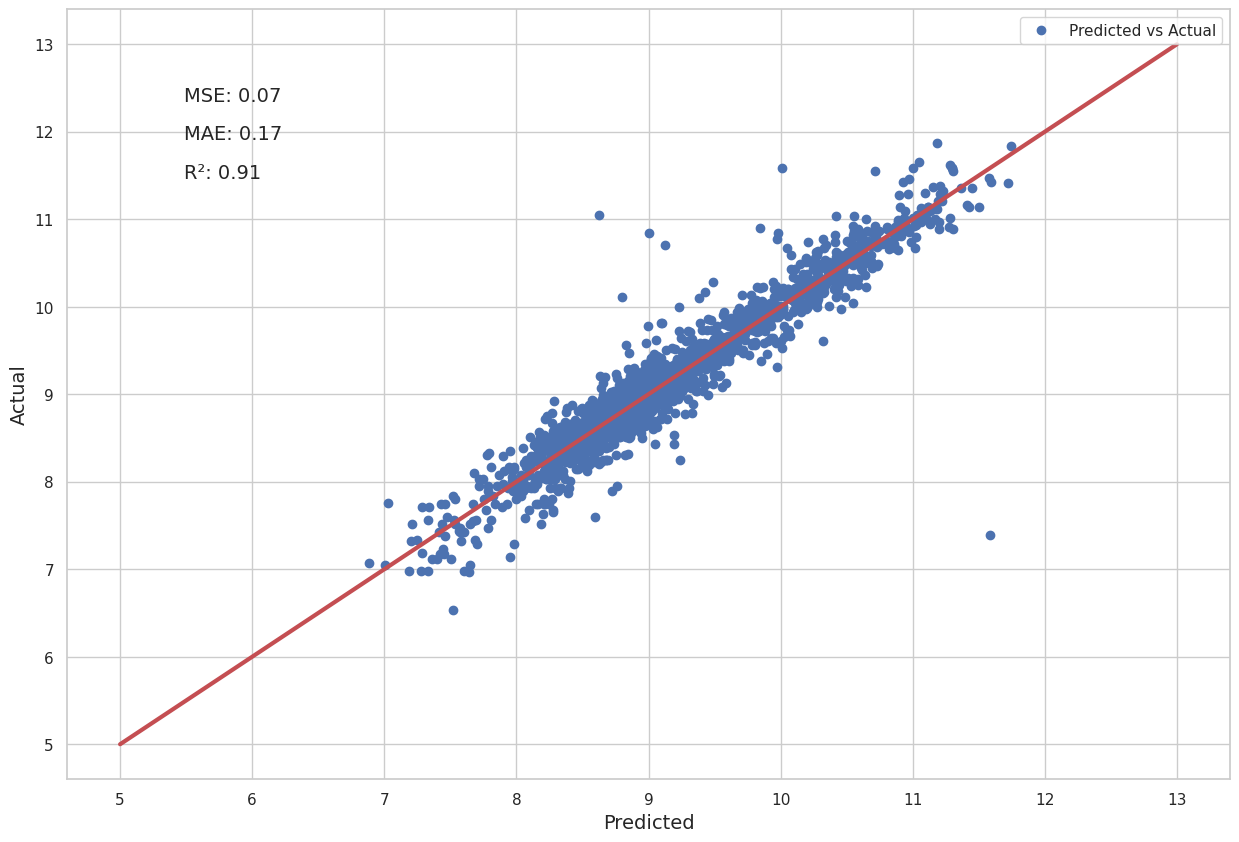

In [79]:
gb_reg = GradientBoostingRegressor(alpha = 0.9, ccp_alpha = 0.0, criterion = 'friedman_mse', init = None, learning_rate = 0.15,\
                                   loss = 'squared_error', max_depth = 4, max_features = None, max_leaf_nodes = None, \
                                   min_impurity_decrease = 0.0, min_samples_leaf = 10, min_samples_split = 70, \
                                   min_weight_fraction_leaf = 0.0, n_estimators = 300, n_iter_no_change = None, random_state = 1234,\
                                   subsample = 1.0, tol = 0.0001, validation_fraction = 0.1, verbose = 0, warm_start = False)
gb_reg.fit(X_train, y_train)

predicted = gb_reg.predict(X_test)
actual = y_test

act_df = pd.DataFrame(actual)
pred_df = pd.DataFrame(predicted)
act_df.reset_index(inplace=True)

act_pred_df = pd.concat([act_df, pred_df], axis=1)
act_pred_df.columns = ['index', 'actual', 'predicted']

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

plt.figure(figsize=(15, 10))
plt.plot(act_pred_df['predicted'], act_pred_df['actual'], 'o', label='Predicted vs Actual')

plt.text(0.1, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.85, f'MAE: {mae:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.text(0.1, 0.8, f'R²: {r2:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
line = plt.plot([5, 13], [5, 13], color='r', linewidth=3.0)
plt.legend()
plt.show()

Text(0, 0.5, 'Feature')

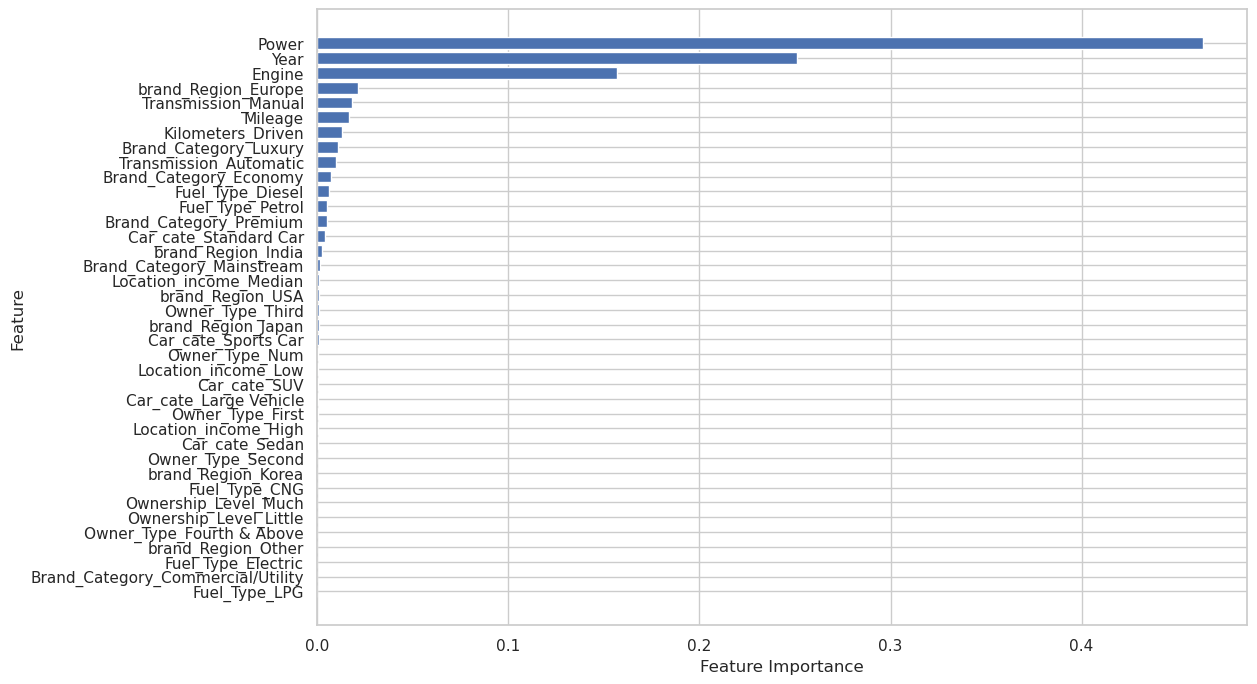

In [80]:
gb_importance = pd.DataFrame()
gb_importance['Feature'] = v_feature_name
gb_importance['Importance'] = gb_reg.feature_importances_

gb_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(gb_importance))
plt.figure(figsize=(12, 8))
plt.barh(y = coordinates, width = gb_importance['Importance'])
plt.yticks(coordinates, gb_importance['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

- 모든 모델의 성능을 참고해봤을때 XGBoost 모델의 성능이 현 데이터에 가장 적합할 것으로 판단됩니다.
- Price가 결측값인 데이터의 Price 값을 예측하기 위해, 결측값이 없는 데이터를 사용하여 모델을 학습시키고, 이를 통해 Price 값을 예측합니다.
- 피처 중요도를 산출하여 유의미한 인자를 출력합니다.
- 현재시점 인도의 중고차 가격과 예측가격을 비교하여 모델의 성능평가를 진행합니다.

In [81]:
# param_grid = {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#         'max_depth': [i for i in range(1,7)],
#         'min_samples_split': [i*10 for i in range(3,8)],
#         'min_samples_leaf': [i*5 for i in range(2,5)]}

# gb_reg = GradientBoostingRegressor(random_state=1234)
# grid_search = GridSearchCV(estimator=gb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(df_x, df_y)
# best_gb_reg = grid_search.best_estimator_
# best_params = best_gb_reg.get_params()
# print("Best Hyperparameters:", best_params)

In [82]:
df_mis_price.drop(columns=['Location', 'Price', 'Name', 'Seats', 'Brand', 'Price'], inplace=True)
df_mis_price_onehot = pd.get_dummies(df_mis_price)
df_x.drop(columns=['Fuel_Type_Electric', 'Owner_Type_Fourth & Above'], inplace=True)

gb_reg_final = GradientBoostingRegressor(alpha = 0.9, ccp_alpha = 0.0, criterion = 'friedman_mse', init = None, learning_rate = 0.2,\
                                   loss = 'squared_error', max_depth = 4, max_features = None, max_leaf_nodes = None, \
                                   min_impurity_decrease = 0.0, min_samples_leaf = 10, min_samples_split = 40, \
                                   min_weight_fraction_leaf = 0.0, n_estimators = 300, n_iter_no_change = None, random_state = 1234,\
                                   subsample = 1.0, tol = 0.0001, validation_fraction = 0.1, verbose = 0, warm_start = False)

gb_reg_final.fit(df_x, df_y)

predicted = gb_reg_final.predict(df_mis_price_onehot)
fin = np.expm1(predicted)
df_mis_price_onehot['price_predict'] = fin

Text(0, 0.5, 'Feature')

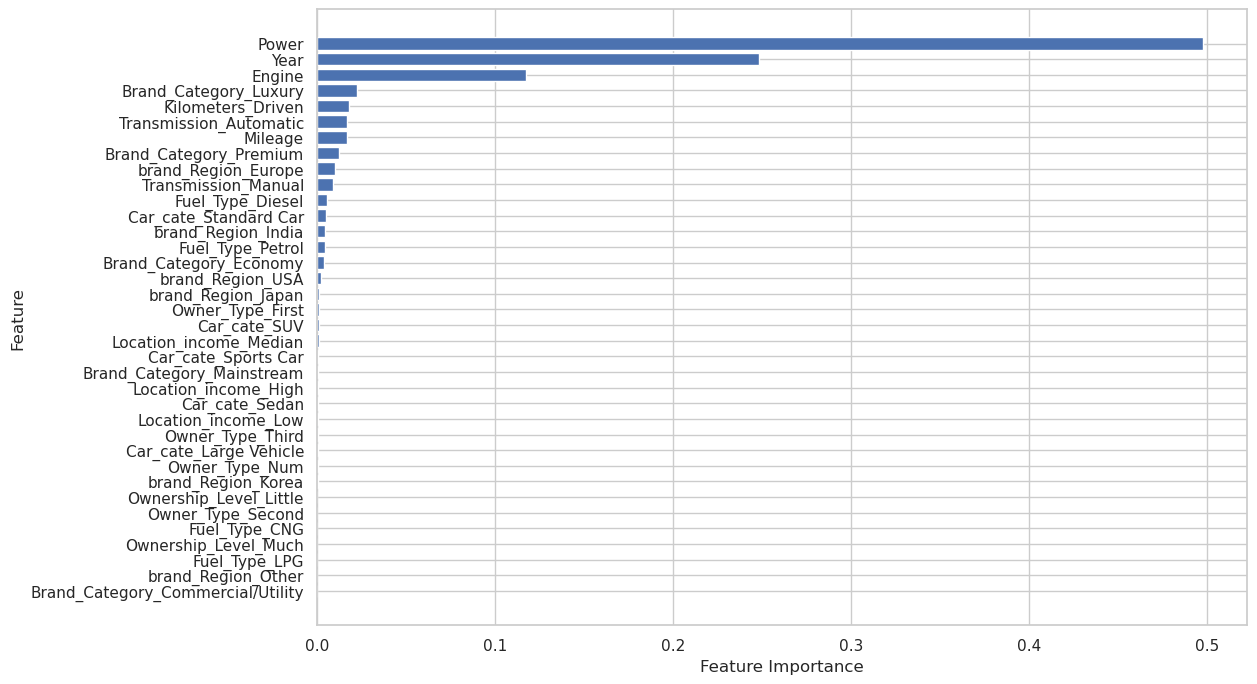

In [84]:
v_feature_name = df_x.columns

rf_importance = pd.DataFrame()
rf_importance['Feature'] = v_feature_name
rf_importance['Importance'] = gb_reg_final.feature_importances_

rf_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(rf_importance))
plt.figure(figsize=(12, 8))
plt.barh(y = coordinates, width = rf_importance['Importance'])
plt.yticks(coordinates, rf_importance['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')